# Import Libraries and Constants

In [1]:
%matplotlib inline
import torch as th
#import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skorch import NeuralNetRegressor, NeuralNet, callbacks
import utils
import architecture
import run_config
import csv
import json
from pandas._libs.lib import is_integer

In [2]:
#NUM_ROUNDS = run_config.server_config["num_rounds"]
NUM_ROUNDS = 75

In [192]:
FL_PATH = '../ag_-1/fl_model_Final_500_batch_NAdam_UP_10ag_75rnd_5ep_0qt_0SMPCn.pt'

In [193]:
FL_NUM_UNITS_1 = 10

In [194]:
FL_NUM_UNITS_2 = 15

In [195]:
NUM_FEATURES = run_config.model_architecture["num_features"]

# Load Models

Get number of units from neural network

In [196]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

params_key  mean_fit_time  std_fit_time  mean_score_time  \
0    0.001_15_10     676.567914           0.0         0.677765   
1     0.01_15_15     620.638456           0.0         0.595407   
2     0.001_5_15     672.071368           0.0         0.697492   
3      0.01_5_15     653.678059           0.0         0.680921   
4     0.001_5_10     714.939453           0.0         0.668720   
..           ...            ...           ...              ...   
193    0.01_10_5      60.795798           0.0         0.057846   
194   0.01_15_10      61.890233           0.0         0.056847   
195    0.01_5_15      61.705813           0.0         0.060839   
196   0.01_10_15      61.954480           0.0         0.065823   
197   0.01_15_15      62.098127           0.0         0.060864   

     std_score_time  param_optimizer__lr  param_module__num_units_2  \
0               0.0                0.001                         15   
1               0.0                0.010                         15   
2               0.0                0.001                          5   
3               0.0                0.010                          5   
4               0.0                0.001                          5   
..              ...                  ...                        ...   
193             0.0                0.010                         10   
194             0.0                0.010                         15   
195             0.0                0.010                          5   
196             0.0                0.010                         10   
197             0.0                0.010                         15   

     param_module__num_units_1  \
0                           10   
1                           15   
2                           15   
3                           15   
4                           10   
..                         ...   
193                          5   
194                         10   
195                         15   
196                         15   
197                         15   

                                                params  split0_test_score  \
0    {'optimizer__lr': 0.001, 'module__num_units_2'...           0.053005   
1    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.052909   
2    {'optimizer__lr': 0.001, 'module__num_units_2'...           0.050171   
3    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.049549   
4    {'optimizer__lr': 0.001, 'module__num_units_2'...           0.048527   
..                                                 ...                ...   
193  {'optimizer__lr': 0.01, 'module__num_units_2':...           0.011111   
194  {'optimizer__lr': 0.01, 'module__num_units_2':...           0.006614   
195  {'optimizer__lr': 0.01, 'module__num_units_2':...          -0.000857   
196  {'optimizer__lr': 0.01, 'module__num_units_2':...          -0.002996   
197  {'optimizer__lr': 0.01, 'module__num_units_2':...          -0.026478   

     ...  test_mean_poisson_deviance  test_weighted_mean_poisson_deviance  \
0    ...                    0.297035                             0.345917   
1    ...                    0.297035                             0.345917   
2    ...                    0.297035                             0.345917   
3    ...                    0.297035                             0.345917   
4    ...                    0.297035                             0.345917   
..   ...                         ...                                  ...   
193  ...                    0.303493                             0.351045   
194  ...                    0.303493                             0.351045   
195  ...                    0.303493                             0.351045   
196  ...                    0.303493                             0.351045   
197  ...                    0.303493                             0.351045   

     test_pde  test_weighted_pde  test_r^2  test_gini  test_min_pred  \
0    0.070028           0.048

Filter to just best hyperparameters

In [197]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

params_key  mean_fit_time  std_fit_time  mean_score_time  \
0    0.001_15_10     676.567914           0.0         0.677765   
18     0.001_5_5      60.499486           0.0         0.060808   
36    0.001_5_10      61.300311           0.0         0.061863   
54      0.01_5_5      60.514535           0.0         0.059840   
72      0.01_5_5      60.662380           0.0         0.063829   
90   0.001_10_15      61.701816           0.0         0.057846   
108     0.01_5_5      60.515734           0.0         0.060863   
126   0.001_15_5      60.876188           0.0         0.056848   
144  0.001_10_15      61.975997           0.0         0.058842   
162   0.001_15_5      61.299149           0.0         0.071808   
180  0.001_10_15      62.155848           0.0         0.065824   

     std_score_time  param_optimizer__lr  param_module__num_units_2  \
0               0.0                0.001                         15   
18              0.0                0.001                          5   
36              0.0                0.001                          5   
54              0.0                0.010                          5   
72              0.0                0.010                          5   
90              0.0                0.001                         10   
108             0.0                0.010                          5   
126             0.0                0.001                         15   
144             0.0                0.001                         10   
162             0.0                0.001                         15   
180             0.0                0.001                         10   

     param_module__num_units_1  \
0                           10   
18                           5   
36                          10   
54                           5   
72                           5   
90                          15   
108                          5   
126                          5   
144                         15   
162                          5   
180                         15   

                                                params  split0_test_score  \
0    {'optimizer__lr': 0.001, 'module__num_units_2'...           0.053005   
18   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.034765   
36   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.049944   
54   {'optimizer__lr': 0.01, 'module__num_units_2':...           0.040448   
72   {'optimizer__lr': 0.01, 'module__num_units_2':...           0.048975   
90   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.034174   
108  {'optimizer__lr': 0.01, 'module__num_units_2':...           0.026247   
126  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.027162   
144  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.024785   
162  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.037106   
180  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.037938   

     ...  test_mean_poisson_deviance  test_weighted_mean_poisson_deviance  \
0    ...                    0.297035                             0.345917   
18   ...                    0.304710                             0.352555   
36   ...                    0.304334                             0.352838   
54   ...                    0.303282                             0.351642   
72   ...                    0.302639                             0.351485   
90   ...                    0.303326                             0.351111   
108  ...                    0.304455                             0.353963   
126  ...                    0.307567                             0.353484   
144  ...                    0.304328                             0.351672   
162  ...                    0.305494                             0.352889   
180  ...                    0.303493                             0.351045   

     test_pde  test_weighted_pde  test_r^2  test_gini  test_min_pred  \
0    0.070028           0.048

In [198]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

agent  param_module__num_units_1  param_module__num_units_2
0       -1                         10                         15
18       0                          5                          5
36       1                         10                          5
54       2                          5                          5
72       3                          5                          5
90       4                         15                         10
108      5                          5                          5
126      6                          5                         15
144      7                         15                         10
162      8                          5                         15
180      9                         15                         10

Create dictionary to lookup hyperparameters

In [199]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 10, 'param_module__num_units_2': 15},
 0: {'param_module__num_units_1': 5, 'param_module__num_units_2': 5},
 1: {'param_module__num_units_1': 10, 'param_module__num_units_2': 5},
 2: {'param_module__num_units_1': 5, 'param_module__num_units_2': 5},
 3: {'param_module__num_units_1': 5, 'param_module__num_units_2': 5},
 4: {'param_module__num_units_1': 15, 'param_module__num_units_2': 10},
 5: {'param_module__num_units_1': 5, 'param_module__num_units_2': 5},
 6: {'param_module__num_units_1': 5, 'param_module__num_units_2': 15},
 7: {'param_module__num_units_1': 15, 'param_module__num_units_2': 10},
 8: {'param_module__num_units_1': 5, 'param_module__num_units_2': 15},
 9: {'param_module__num_units_1': 15, 'param_module__num_units_2': 10}}

Use dictionary to access results, for example to lookup `agent=0`:

In [200]:
top_results_dict[-1]

{'param_module__num_units_1': 10, 'param_module__num_units_2': 15}

In [201]:
list(top_results_dict[-1].items())[0][1]

10

In [202]:
list(top_results_dict[-1].items())[1][1]

15

## Create load model function

In [203]:
def load_model(agent=-1, num_features=NUM_FEATURES):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]
    #num_units_3 = list(top_results_dict[agent].items())[2][1]

    loaded_agent_model = NeuralNetRegressor(architecture.MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [204]:
NUM_AGENTS = 10

In [205]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

## Load Federated Model

In [206]:
fl_model = architecture.MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
fl_model

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act1): Tanh()
  (act2): Tanh()
)

In [207]:
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act1): Tanh()
  (act2): Tanh()
)

Again can lookup each agent's model

In [208]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=5, bias=True)
    (layer_2): Linear(in_features=5, out_features=5, bias=True)
    (layer_out): Linear(in_features=5, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act1): Tanh()
    (act2): Tanh()
  ),
)

## Load global model

In [209]:
loaded_agent_global_model = load_model(agent=-1)

# Load Test Data and Functions

In [210]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [211]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [212]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [213]:
X_test, y_test, df_test = create_test_data()

In [214]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    # Global Model Predictions
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    # FL Model Predictions
    y_fl_pred = fl_model.predict(th.tensor(X_test).float())
    df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred.flatten().detach().numpy())

    # Local Model Predictions

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [215]:
def create_df_sum(df_test_pred, factor, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model'}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [216]:
def one_way_graph_comparison(factor, agents_to_graph_list):

        #NUM_AGENTS = len(agents_to_graph_list)

        df_sum = create_df_sum(df_test_pred, factor, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in agents_to_graph_list:
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                #linestyle=(0, (1, 10)),
                linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred FL model'],  
                label='Freq pred FL model',
                marker='o',
                markersize=10,
                #linestyle='dotted',
                )
        
        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+' binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.title('Actual vs. Expected by '+factor)
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# Learning Curves

In [217]:
def read_csv(filename):
    loss_stats_dict = dict()
    with open(filename) as f:
        file_data=csv.reader(f)
        headers=next(file_data)
        round = 0
        for i in file_data:
            loss_stats_dict[round] = dict(zip(headers,i))
            round +=1
    return loss_stats_dict

In [218]:
loss_stats = dict()
for ag_id in range(-1, NUM_AGENTS):
    if ag_id == -1:
        MY_DATA_PATH = '../../../prod_Xavier_init/IFoA-FL-WP/ag_global'
    else:    
        MY_DATA_PATH = '../../../prod_Xavier_init/IFoA-FL-WP/ag_' + str(ag_id)
    
    loss_stats[ag_id] = read_csv(MY_DATA_PATH + '/los_stats.csv')

In [219]:
for ag in range(0,10):
    
    loss_train_list = []
    loss_val_list = []
    
    for rnd_no in range(0, NUM_ROUNDS):
    #for rnd_no in range(0, NUM_ROUNDS*2 +1):
                    if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                        y_train_loss = json.loads(loss_stats[ag][rnd_no]["train"])
                        loss_train_list.extend(y_train_loss)
                        y_val_loss = json.loads(loss_stats[ag][rnd_no]["val"])
                        loss_val_list.extend(y_val_loss)
    
    print('Agent '+str(ag)+' Generalisation Loss: '+str(loss_val_list[-1]/min(loss_train_list[:])))

Agent 0 Generalisation Loss: 1.1379866073962652
Agent 1 Generalisation Loss: 1.2252329716815797
Agent 2 Generalisation Loss: 1.0637679065486154
Agent 3 Generalisation Loss: 1.080764400798514
Agent 4 Generalisation Loss: 1.0456872283984853
Agent 5 Generalisation Loss: 1.125448914240064
Agent 6 Generalisation Loss: 1.1435317981625364
Agent 7 Generalisation Loss: 1.068548635967685
Agent 8 Generalisation Loss: 1.0755311123426843
Agent 9 Generalisation Loss: 1.1672905812943701


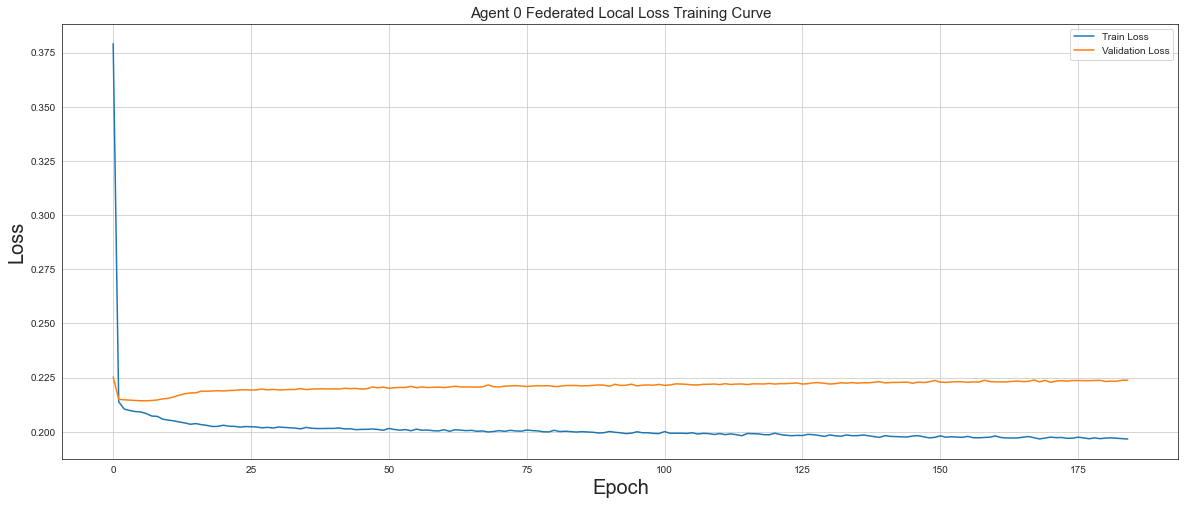

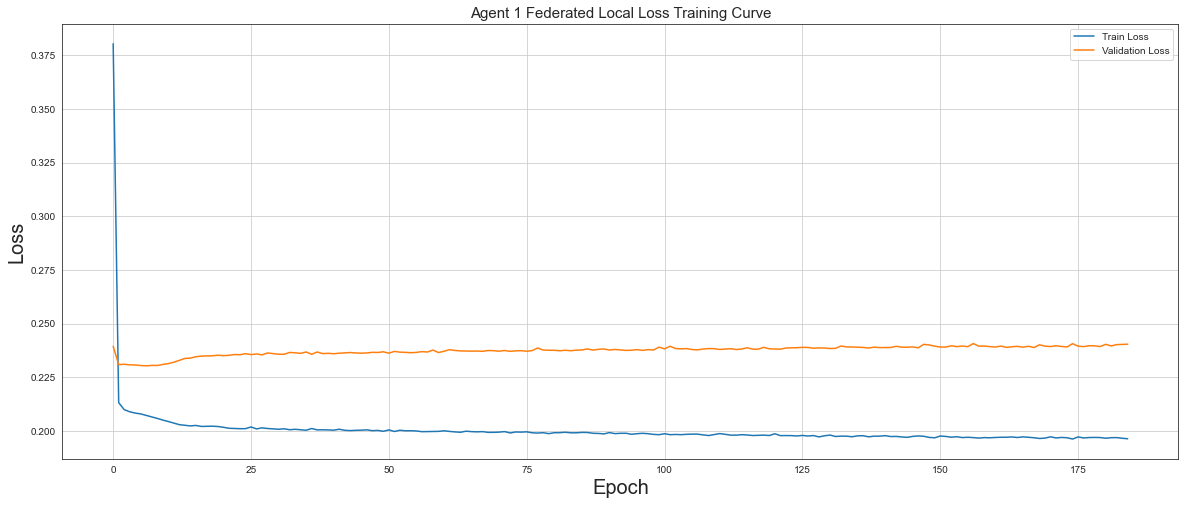

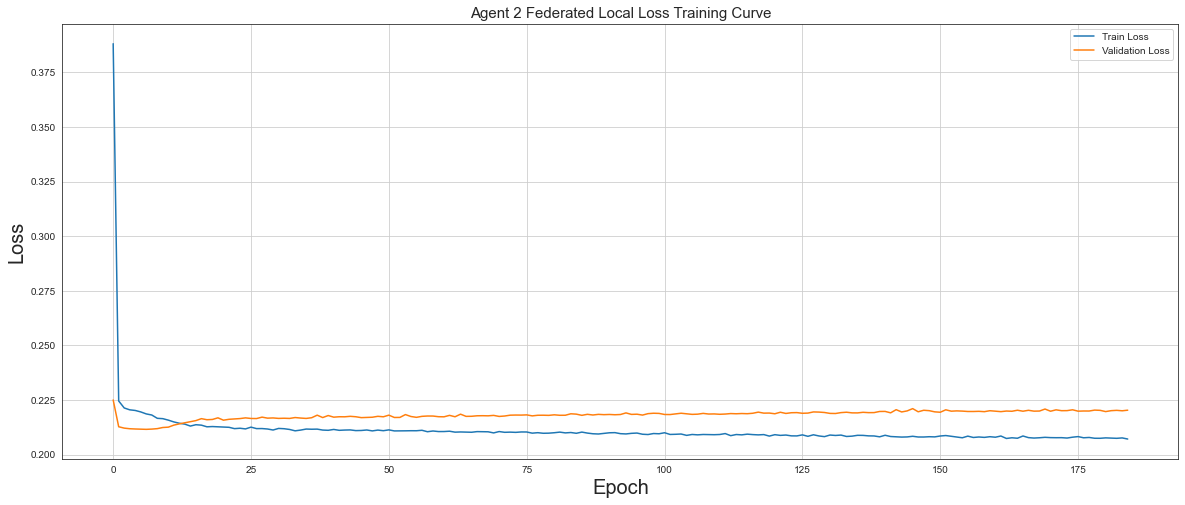

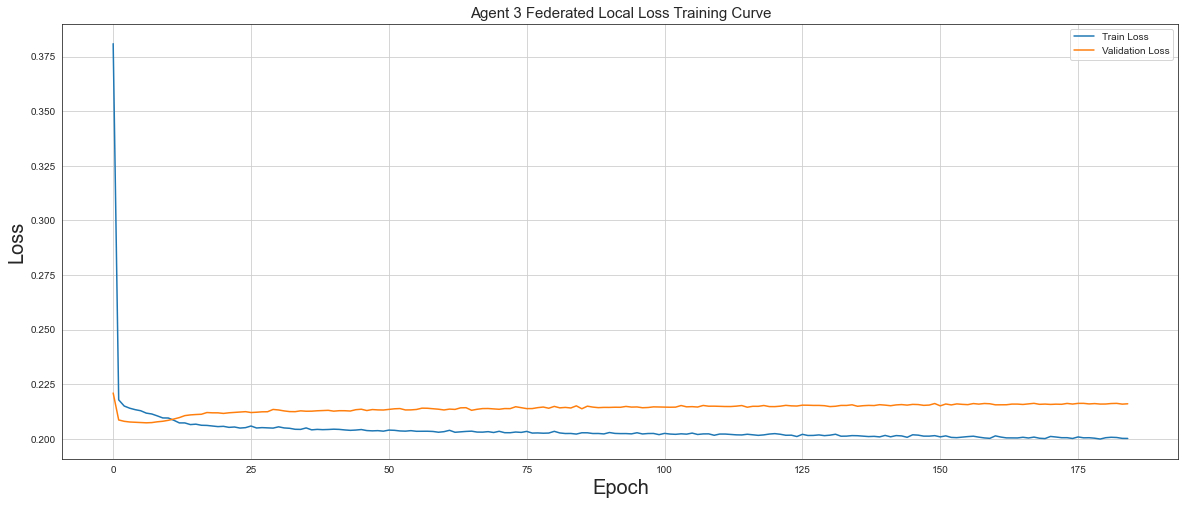

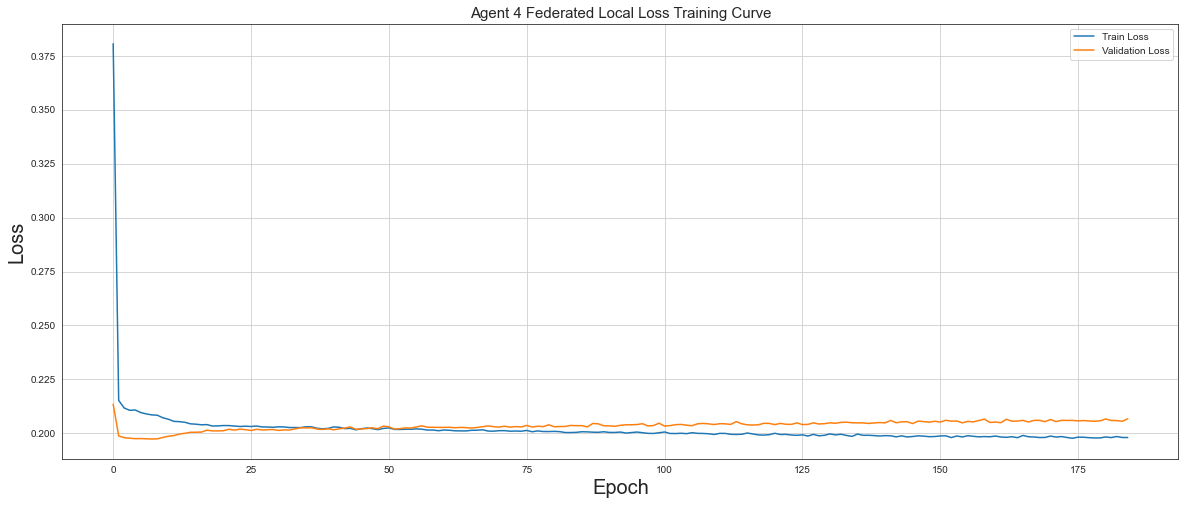

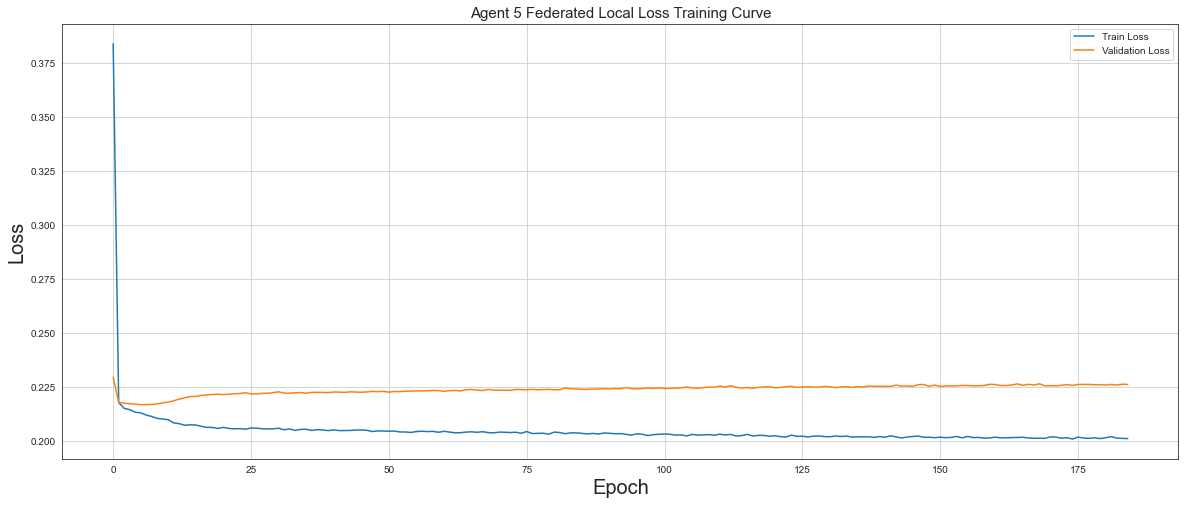

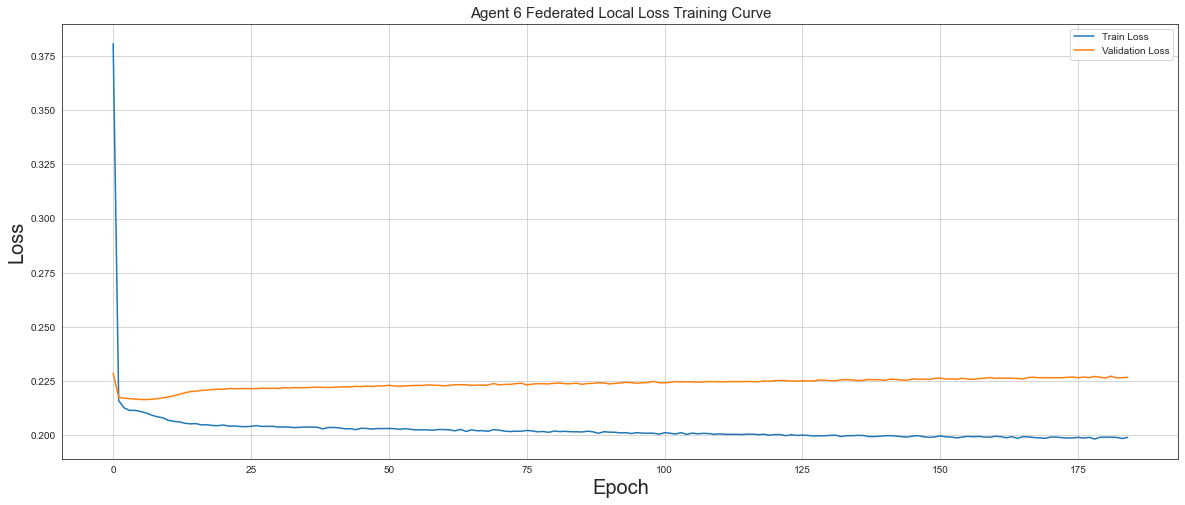

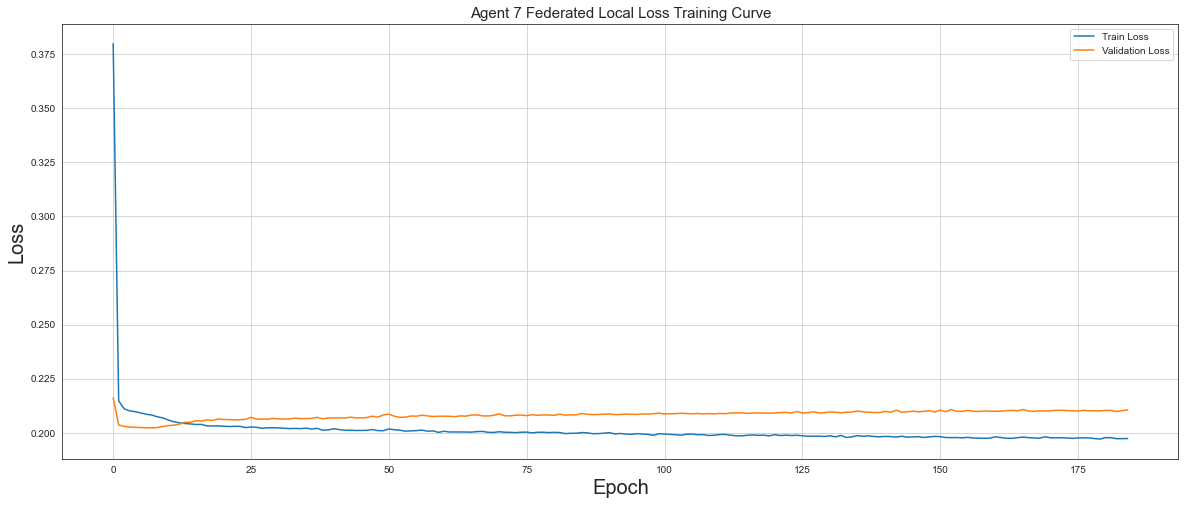

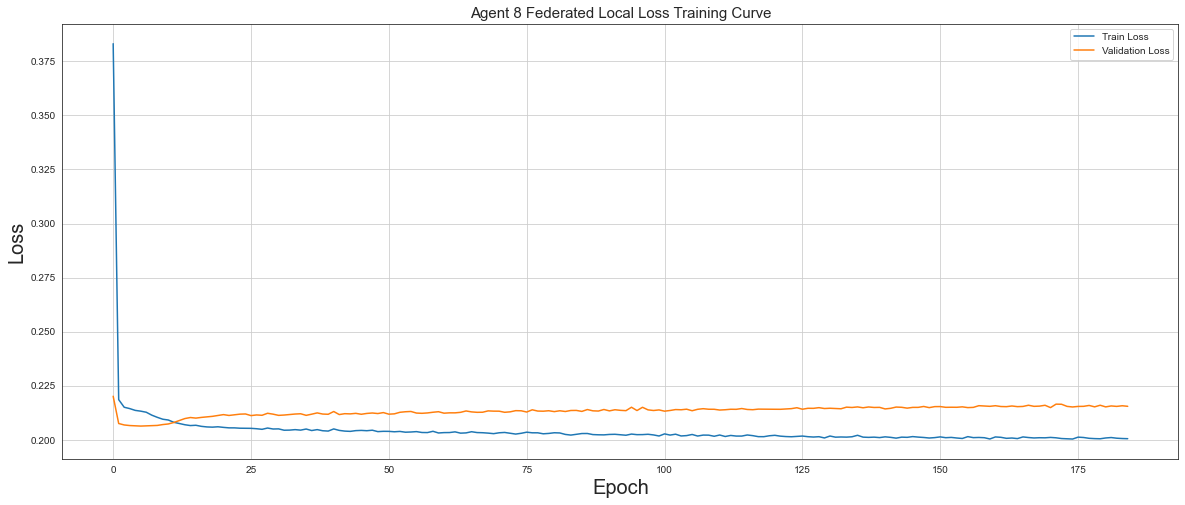

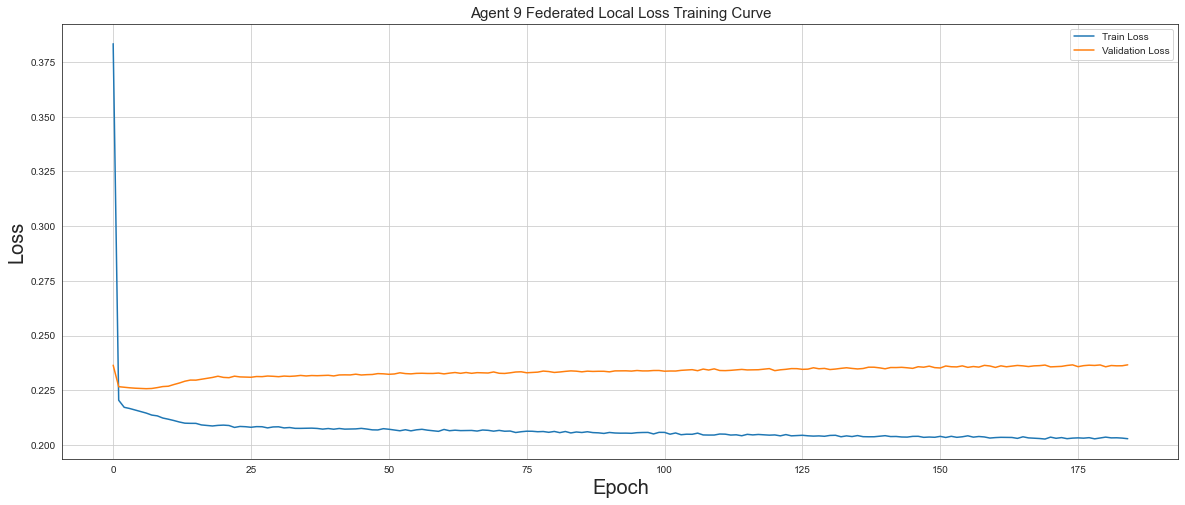

In [220]:
for ag in range(0,10):
    
    loss_train_list = []
    loss_val_list = []
    
    for rnd_no in range(0, NUM_ROUNDS):
    #for rnd_no in range(0, NUM_ROUNDS*2 +1):
                    if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                        y_train_loss = json.loads(loss_stats[ag][rnd_no]["train"])
                        loss_train_list.extend(y_train_loss)
                        y_val_loss = json.loads(loss_stats[ag][rnd_no]["val"])
                        loss_val_list.extend(y_val_loss)
    
    plt.figure(figsize=(20,8))
    plt.plot(loss_train_list[:], label='Train Loss')
    plt.plot(loss_val_list[:], label='Validation Loss')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.title(f'Agent {ag} Federated Local Loss Training Curve', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()

# One Way AvE Graphs

Create dataset to graph

In [221]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)

Define agents to graph

In [222]:
agents_to_graph_list = [9]

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


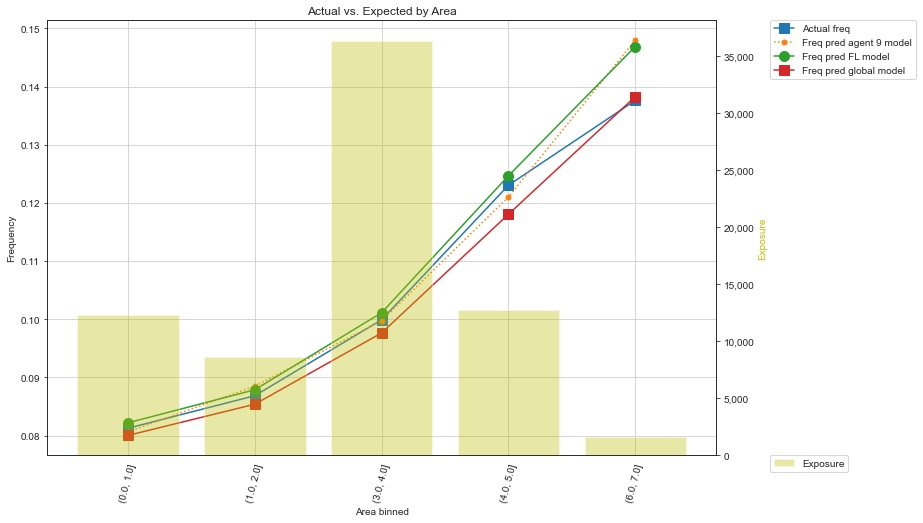

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


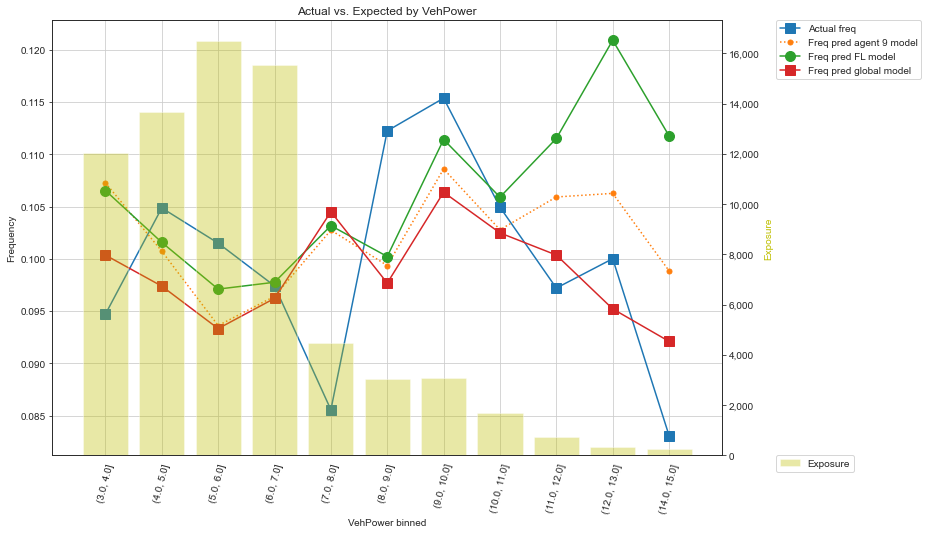

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


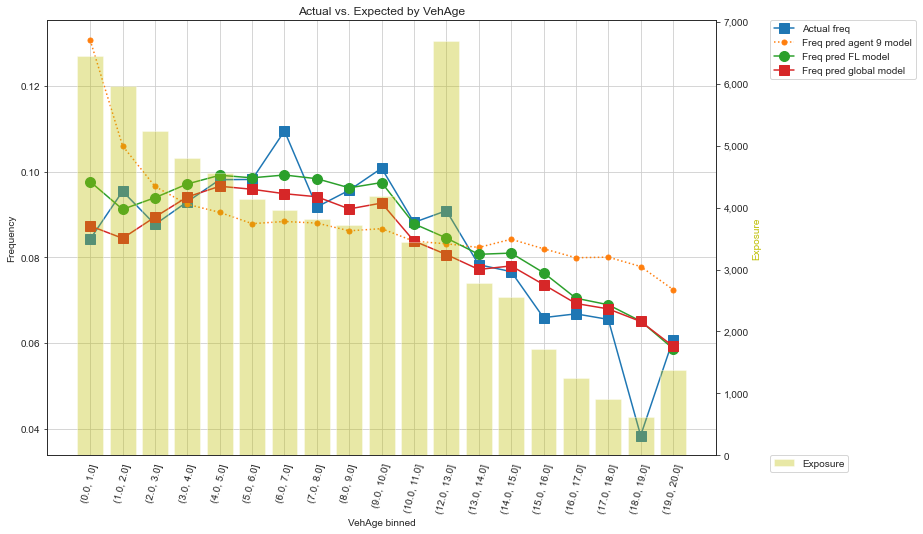

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


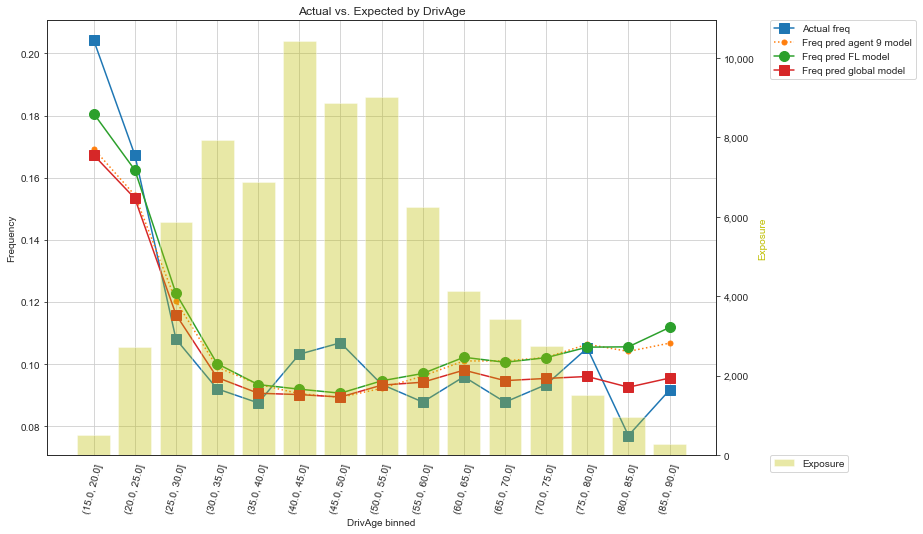

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


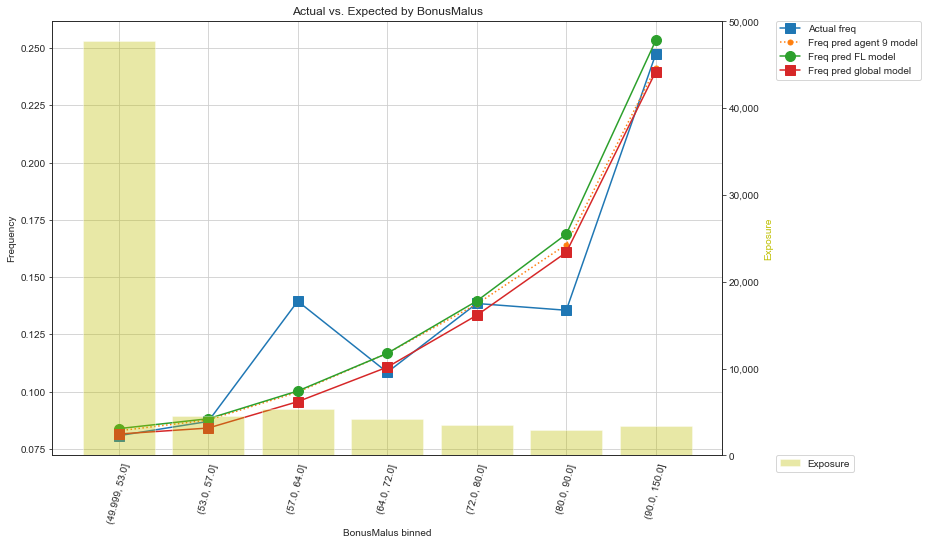

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


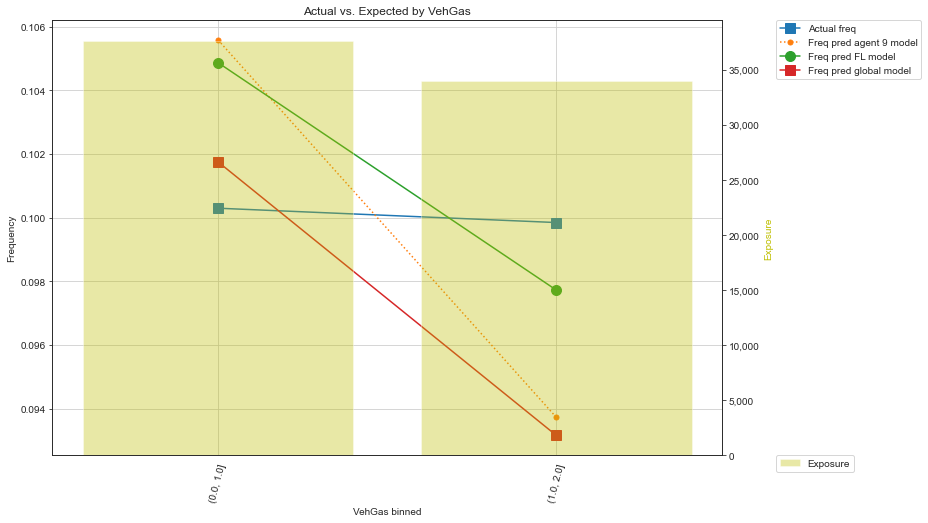

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


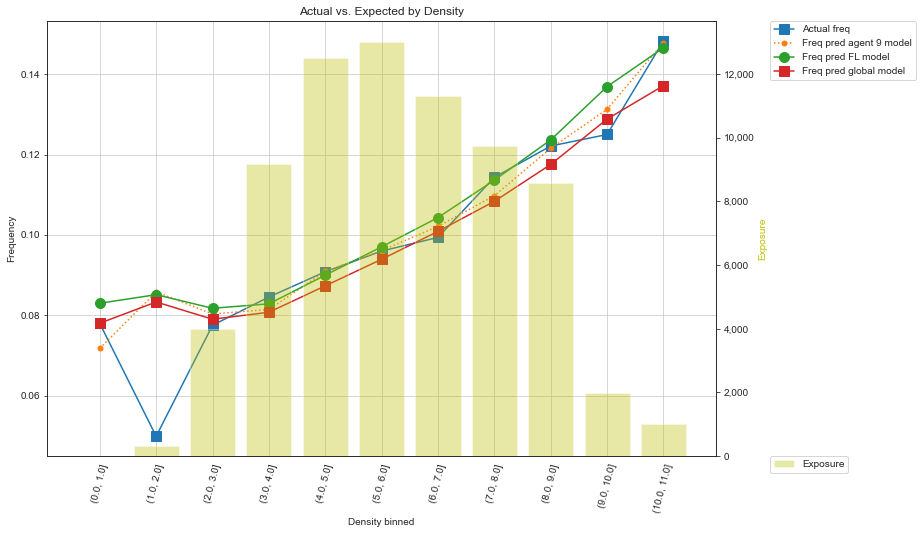

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


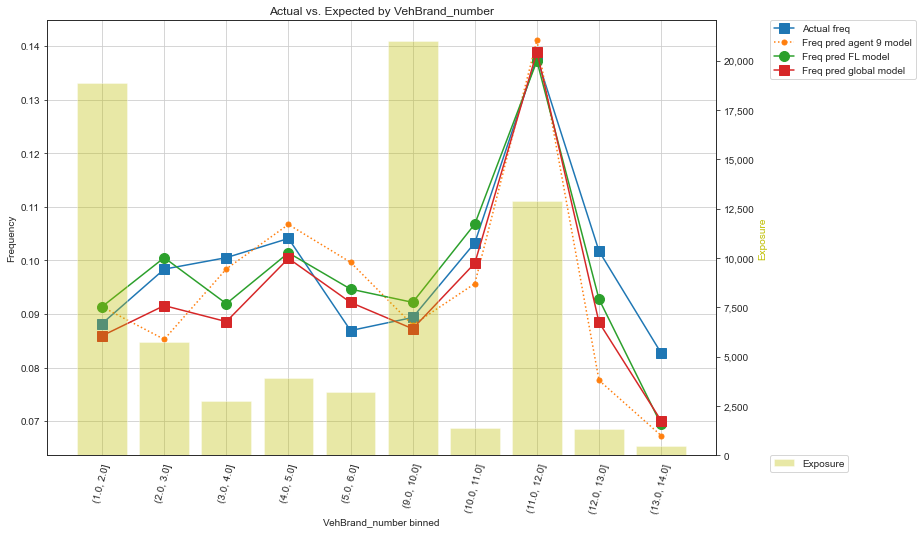

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1880313607.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


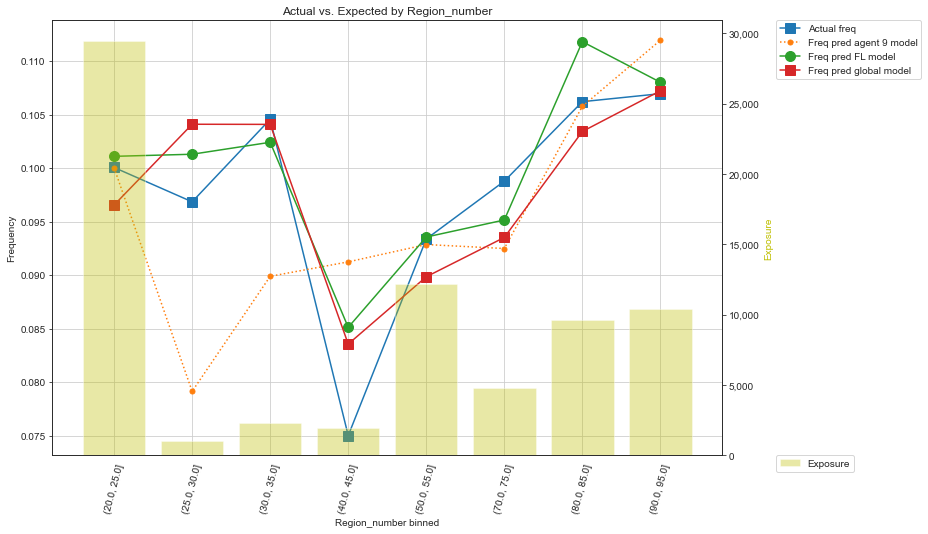

In [223]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, agents_to_graph_list)

# Lift Charts

In [319]:
#def weighted_qcut(values, weights, q, **kwargs):
    #'Return weighted quantile cuts from a given series, values.'
    #if is_integer(q):
        #quantiles = np.linspace(0, 1, q + 1)
    #else:
        #quantiles = q
    #order = weights.iloc[values.argsort()].cumsum()
    #bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    #return bins.sort_index()

In [320]:
df_test_pred['fl_vs_9'] = df_test_pred['ClaimNb_fl_pred']/df_test_pred['ClaimNb_agent_9_pred']

In [321]:
#df_test_pred['risk_bucket'] = weighted_qcut(df_test_pred['ClaimNb_pred'], df_test_pred['Exposure'], 10, labels=False)
df_test_pred['fl_vs_9_binned'] = pd.qcut(df_test_pred['fl_vs_9'], 10)
df_test_pred

Exposure  Area  VehPower  VehAge  DrivAge  BonusMalus  VehGas  \
0       1.000000   1.0       4.0    11.0     45.0        50.0     1.0   
1       0.700000   3.0       7.0     3.0     26.0        68.0     1.0   
2       0.460000   4.0       9.0    15.0     21.0        95.0     1.0   
3       0.450000   5.0       4.0     0.0     69.0        50.0     1.0   
4       0.490000   6.0       9.0     1.0     57.0        50.0     1.0   
...          ...   ...       ...     ...      ...         ...     ...   
135598  0.070000   3.0       9.0     0.0     53.0        50.0     1.0   
135599  0.110000   3.0       9.0    16.0     37.0        50.0     1.0   
135600  0.008219   4.0       7.0     0.0     56.0        50.0     1.0   
135601  0.280000   5.0       5.0    17.0     50.0        90.0     1.0   
135602  0.210000   2.0      10.0     5.0     68.0        50.0     2.0   

          Density VehBrand Region  ...  global_vs_4  global_vs_5  global_vs_6  \
0        2.197225       B3    R24  ...     1.523129     1.925116     1.551642   
1        5.774552       B6    R31  ...     0.388070     0.636600     0.649139   
2        6.960348       B3    R24  ...     0.979541     1.128175     0.675384   
3        8.325548      B12    R52  ...     0.697239     1.106143     0.286061   
4       10.060320       B2    R21  ...     0.679107     1.157932     1.103691   
...           ...      ...    ...  ...          ...          ...          ...   
135598   5.953243      B12    R82  ...     1.571825     1.538420     0.363304   
135599   6.003887      B14    R24  ...     1.470890     1.009826     1.296330   
135600   6.628041      B12    R26  ...     0.929487     0.824278     0.267109   
135601   9.138522       B5    R82  ...     0.624609     0.541351     0.657226   
135602   4.430817      B12    R52  ...     0.893599     0.727217     1.247955   

       global_vs_7 global_vs_8 global_vs_9 global_vs_fl_binned   fl_vs_9  \
0         1.394835    1.643029    1.423810      (1.191, 1.303]  0.849494   
1         0.758603    0.710088    0.800075       (1.004, 1.04]  1.267493   
2         0.950341    1.101736    0.977332      (0.206, 0.846]  0.791596   
3         0.312310    0.610114    0.562348      (0.965, 1.004]  1.730742   
4         1.062160    1.018517    1.152313      (1.127, 1.191]  0.978412   
...            ...         ...         ...                 ...       ...   
135598    0.752627    0.624881    0.725267       (1.08, 1.127]  1.535412   
135599    1.523248    0.973519    1.408807       (1.303, 4.19]  1.013335   
135600    0.336131    0.756324    0.289330      (0.206, 0.846]  2.033132   
135601    0.868338    0.703844    1.094930       (1.004, 1.04]  0.939070   
135602    0.843848    0.685344    0.812189      (0.965, 1.004]  1.223379   

        fl_vs_9_binned global_vs_9_binned  
0       (0.771, 0.857]     (0.771, 0.857]  
1        (1.19, 1.321]      (1.19, 1.321]  
2       (0.771, 0.857]     (0.771, 0.857]  
3       (1.519, 5.729]     (1.519, 5.729]  
4       (0.934, 1.008]     (0.934, 1.008]  
...                ...                ...  
135598  (1.519, 5.729]     (1.519, 5.729]  
135599  (1.008, 1.088]     (1.008, 1.088]  
135600  (1.519, 5.729]     (1.519, 5.729]  
135601  (0.934, 1.008]     (0.934, 1.008]  
135602   (1.19, 1.321]      (1.19, 1.321]  

[135603 rows x 50 columns]

In [322]:
sum_list = ['Exposure',  
            'ClaimNb', 
            'ClaimNb_pred', 
            'ClaimNb_fl_pred', 
            'ClaimNb_agent_0_pred', 
            'ClaimNb_agent_1_pred',
            'ClaimNb_agent_2_pred',
            'ClaimNb_agent_3_pred',
            'ClaimNb_agent_4_pred',
            'ClaimNb_agent_5_pred',
            'ClaimNb_agent_6_pred',
            'ClaimNb_agent_7_pred',
            'ClaimNb_agent_8_pred',
            'ClaimNb_agent_9_pred',
            ]

df_sum=df_test_pred.groupby(['fl_vs_9_binned'])[sum_list].sum().reset_index()
df_sum['ClaimNb_rebased'] = df_sum['ClaimNb']/df_sum['ClaimNb']
df_sum['ClaimNb_pred_rebased'] = df_sum['ClaimNb_pred']/df_sum['ClaimNb']
df_sum['ClaimNb_fl_pred_rebased'] = df_sum['ClaimNb_fl_pred']/df_sum['ClaimNb']
df_sum['ClaimNb_agent_9_pred_rebased'] = df_sum['ClaimNb_agent_9_pred']/df_sum['ClaimNb']
df_sum

fl_vs_9_binned     Exposure  ClaimNb  ClaimNb_pred  ClaimNb_fl_pred  \
0  (0.126, 0.644]  4568.157883    437.0    395.269902       411.797150   
1  (0.644, 0.771]  7399.944073    509.0    508.786782       524.126221   
2  (0.771, 0.857]  8443.621582    614.0    602.441830       622.940186   
3  (0.857, 0.934]  8623.606744    680.0    662.234427       687.449646   
4  (0.934, 1.008]  8712.616333    737.0    718.200772       750.762756   
5  (1.008, 1.088]  8242.556111    779.0    755.408189       791.226624   
6   (1.088, 1.19]  7242.008729    745.0    756.524111       790.273865   
7   (1.19, 1.321]  6496.904617    793.0    790.168838       821.176392   
8  (1.321, 1.519]  6109.521078    895.0    874.048962       900.197021   
9  (1.519, 5.729]  5730.759504    974.0    927.266883       962.743530   

   ClaimNb_agent_0_pred  ClaimNb_agent_1_pred  ClaimNb_agent_2_pred  \
0            782.174302            762.026969            478.424069   
1            748.934344            708.490297            620.414179   
2            792.895281            770.148863            706.117458   
3            826.099549            799.124488            756.841337   
4            848.095957            838.730010            798.193281   
5            840.272567            839.389510            810.267120   
6            779.467626            791.488162            787.879318   
7            746.921536            787.476592            798.715011   
8            748.313444            832.447216            842.018799   
9            702.206632            845.944546            830.811161   

   ClaimNb_agent_3_pred  ClaimNb_agent_4_pred  ClaimNb_agent_5_pred  \
0            465.592414            579.434176            512.532797   
1            595.461430            580.910980            602.438862   
2            677.233319            652.954928            675.195654   
3            730.912171            704.117984            726.060234   
4            781.690378            749.315488            767.943511   
5            813.011256            760.778960            789.695850   
6            787.690180            721.286673            786.412075   
7            789.398652            711.972272            808.539029   
8            822.459246            743.599854            877.225857   
9            824.375578            740.737332            902.803703   

   ClaimNb_agent_6_pred  ClaimNb_agent_7_pred  ClaimNb_agent_8_pred  \
0            747.492332            771.049998            785.407720   
1            677.920478            727.789742            717.567719   
2            699.506884            778.575287            756.544538   
3            723.475441            813.491797            778.145316   
4            738.194721            842.964174            793.273131   
5            727.669540            837.570764            773.203015   
6            683.315109            791.189772            718.593293   
7            660.662103            776.188281            699.034775   
8            663.029873            788.684786            717.404892   
9            625.807325            733.333157            704.806531   

   ClaimNb_agent_9_pred  ClaimNb_rebased  ClaimNb_pred_rebased  \
0            826.024107              1.0              0.904508   
1            735.075956              1.0              0.999581   
2            764.015545              1.0              0.981176   
3            767.054130              1.0              0.973874   
4            773.527647              1.0              0.974492   
5            756.017925              1.0              0.969715   
6            695.384369              1.0              1.015469   
7            655.855831              1.0              0.996430   
8            638.317714              1.0              0.976591   
9            542.283111              1.0              0.952019   

   ClaimNb_fl_pred_rebased  ClaimNb_agent_9_pred_rebased  
0                 0.942328                      1.890215

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\819265062.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


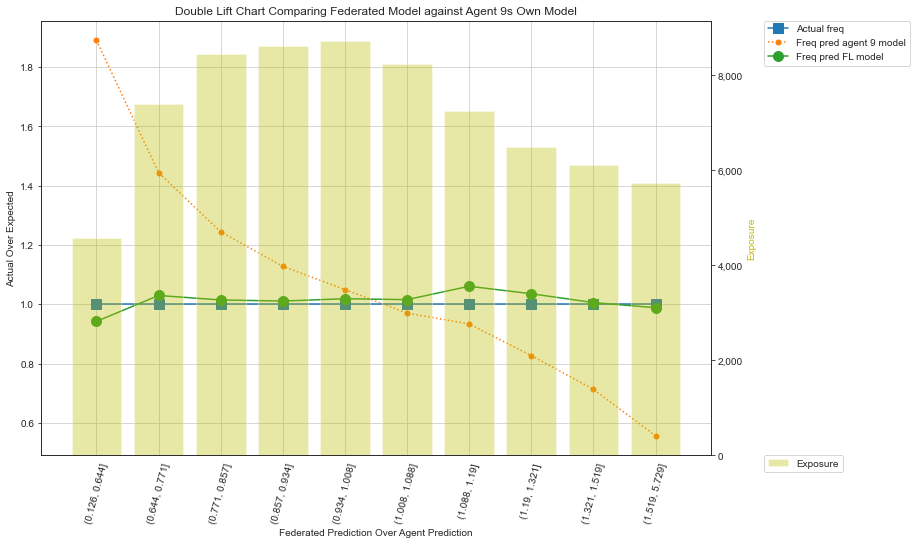

In [324]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_sum['ClaimNb_rebased'],  
        label='Actual freq',
        marker='s',
        markersize=10,
        )

for agents in [9]:
        plt.plot(df_sum['ClaimNb_agent_'+str(agents)+'_pred_rebased'],  
        label='Freq pred agent '+str(agents)+' model',
        marker='o',
        markersize=5,
        #linestyle=(0, (1, 10)),
        linestyle='dotted',
        )

plt.plot(df_sum['ClaimNb_fl_pred_rebased'],  
        label='Freq pred FL model',
        marker='o',
        markersize=10,
        #linestyle='dotted',
        )

#plt.plot(df_sum['ClaimNb_pred_rebased'],  
        #label='Freq pred global model',
        #marker='s',
        #markersize=10,
        #linestyle='dotted',
        #)

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

plt.xlabel('Federated Prediction Over Agent Prediction')
plt.xticks(rotation = 75)
plt.ylabel('Actual Over Expected')
plt.title('Double Lift Chart Comparing Federated Model against Agent 9s Own Model')
plt.grid()


# Get second axis
ax2 = ax.twinx()

plt.bar(df_sum['fl_vs_9_binned'].astype(str), 
        df_sum['Exposure'], 
        label='Exposure', 
        color='y',
        alpha=0.35
        )

plt.ylabel('Exposure', color='y')
plt.xticks(rotation = 90)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

plt.show()

# Gini

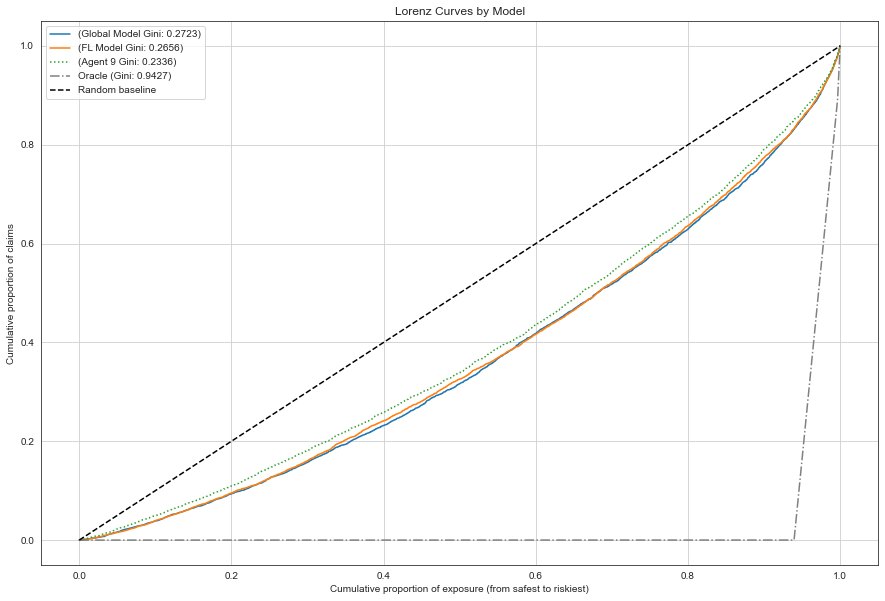

In [229]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.4f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_fl_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(FL Model Gini: {:.4f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in agents_to_graph_list:
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.4f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.4f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric comparison

In [230]:
y_fl_pred = df_test['ClaimNb_fl_pred']

In [135]:
fl_weighted_pde = d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)
fl_weighted_pde

0.04632334621613132

In [231]:
weighted_pde_df = top_results_df[['agent', 'test_weighted_pde']]
weighted_pde_df

agent  test_weighted_pde
0       -1           0.048349
18       0           0.030088
36       1           0.029309
54       2           0.032598
72       3           0.033030
90       4           0.034059
108      5           0.026212
126      6           0.027530
144      7           0.032516
162      8           0.029167
180      9           0.034241

In [232]:
weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\1077199988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]


agent  test_weighted_pde
0     -1.0           0.048349
18     0.0           0.030088
36     1.0           0.029309
54     2.0           0.032598
72     3.0           0.033030
90     4.0           0.034059
108    5.0           0.026212
126    6.0           0.027530
144    7.0           0.032516
162    8.0           0.029167
180    9.0           0.034241
151   -2.0           0.046738

In [233]:
weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde'] - 1
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\2142954441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde'] - 1


agent  test_weighted_pde  fl_relative_increase
0     -1.0           0.048349             -0.033327
18     0.0           0.030088              0.553374
36     1.0           0.029309              0.594651
54     2.0           0.032598              0.433776
72     3.0           0.033030              0.414989
90     4.0           0.034059              0.372239
108    5.0           0.026212              0.783043
126    6.0           0.027530              0.697689
144    7.0           0.032516              0.437360
162    8.0           0.029167              0.602408
180    9.0           0.034241              0.364945
151   -2.0           0.046738              0.000000

In [234]:
weighted_pde_df['model'] = 'Agent'+' '+weighted_pde_df['agent'].astype(int).apply(str)
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\4185987070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['model'] = 'Agent'+' '+weighted_pde_df['agent'].astype(int).apply(str)


agent  test_weighted_pde  fl_relative_increase     model
0     -1.0           0.048349             -0.033327  Agent -1
18     0.0           0.030088              0.553374   Agent 0
36     1.0           0.029309              0.594651   Agent 1
54     2.0           0.032598              0.433776   Agent 2
72     3.0           0.033030              0.414989   Agent 3
90     4.0           0.034059              0.372239   Agent 4
108    5.0           0.026212              0.783043   Agent 5
126    6.0           0.027530              0.697689   Agent 6
144    7.0           0.032516              0.437360   Agent 7
162    8.0           0.029167              0.602408   Agent 8
180    9.0           0.034241              0.364945   Agent 9
151   -2.0           0.046738              0.000000  Agent -2

In [235]:
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -1','Global Model')
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -2','Federated Model')
weighted_pde_df

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\444642117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -1','Global Model')
C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\444642117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -2','Federated Model')


agent  test_weighted_pde  fl_relative_increase            model
0     -1.0           0.048349             -0.033327     Global Model
18     0.0           0.030088              0.553374          Agent 0
36     1.0           0.029309              0.594651          Agent 1
54     2.0           0.032598              0.433776          Agent 2
72     3.0           0.033030              0.414989          Agent 3
90     4.0           0.034059              0.372239          Agent 4
108    5.0           0.026212              0.783043          Agent 5
126    6.0           0.027530              0.697689          Agent 6
144    7.0           0.032516              0.437360          Agent 7
162    8.0           0.029167              0.602408          Agent 8
180    9.0           0.034241              0.364945          Agent 9
151   -2.0           0.046738              0.000000  Federated Model

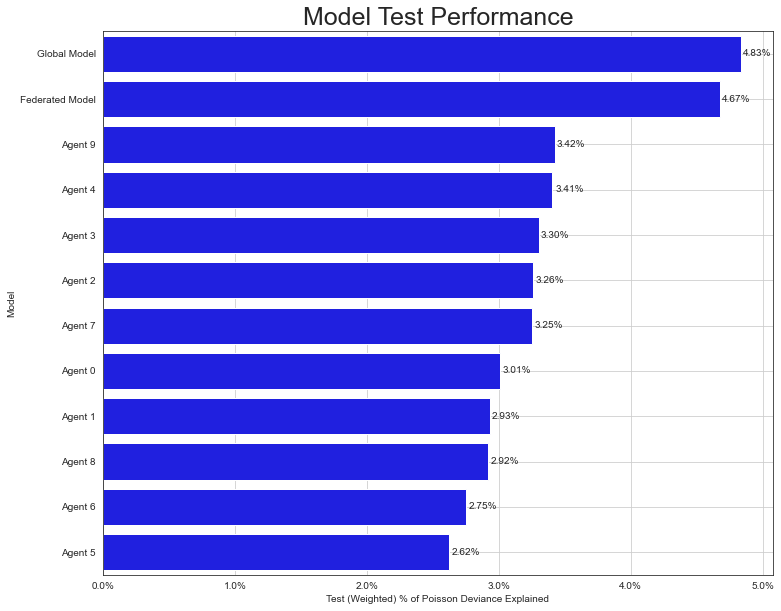

In [236]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='test_weighted_pde',
               data=weighted_pde_df.iloc[0:,:].sort_values(by=['test_weighted_pde'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Model Test Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Model', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
#ax.axvline(global_weighted_pde, ls='--')
#ax.annotate('Global Model Test Performance', xy=(global_weighted_pde, -0.5), horizontalalignment='center', weight='semibold', size='medium')
for i in range(12):
    ax.text(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[0+i:1+i,1],4).tolist()[0]+0.0002, 
            i, 
            '{:.2%}'.format(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[0+i:1+i,1],4).tolist()[0]),
            verticalalignment='center',
            fontdict=(dict(fontsize=10)))
ax.grid(True)
plt.show()

In [237]:
weighted_pde_df_box_plot = weighted_pde_df[['model', 'test_weighted_pde']].loc[(weighted_pde_df['model']!='Global Model') & (weighted_pde_df['model']!='Federated Model')]
weighted_pde_df_box_plot = weighted_pde_df_box_plot.rename(columns={"test_weighted_pde": "Local Agents"})
weighted_pde_df_box_plot['Federated Model'] = max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Federated Model'])
weighted_pde_df_box_plot['Global Model'] = max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Global Model'])
weighted_pde_df_box_plot

model  Local Agents  Federated Model  Global Model
18   Agent 0      0.030088         0.046738      0.048349
36   Agent 1      0.029309         0.046738      0.048349
54   Agent 2      0.032598         0.046738      0.048349
72   Agent 3      0.033030         0.046738      0.048349
90   Agent 4      0.034059         0.046738      0.048349
108  Agent 5      0.026212         0.046738      0.048349
126  Agent 6      0.027530         0.046738      0.048349
144  Agent 7      0.032516         0.046738      0.048349
162  Agent 8      0.029167         0.046738      0.048349
180  Agent 9      0.034241         0.046738      0.048349

C:\Users\dylan\AppData\Local\Temp\ipykernel_19060\2666962247.py:31: UserWarning: You passed a edgecolor/edgecolors ('green') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(1,


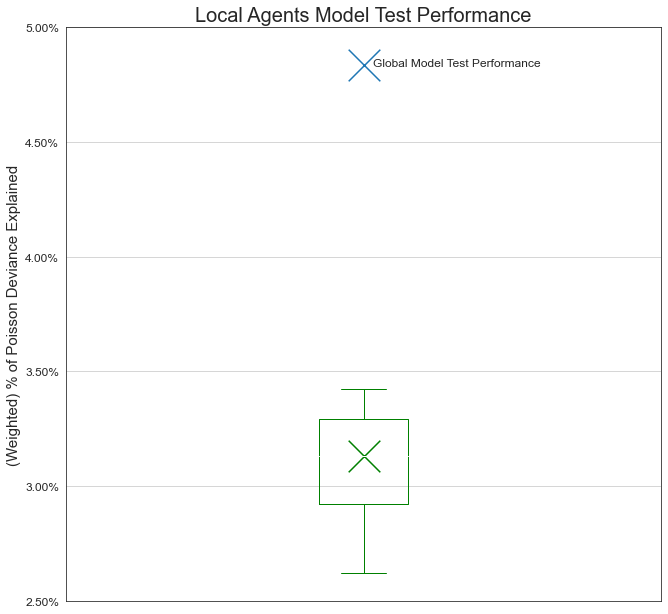

In [238]:
ax = weighted_pde_df_box_plot[['Local Agents']].plot.box(
                                    #vert=False,
                                    #patch_artist=True,
                                    #whis=10
                                    medianprops = dict(linestyle='solid', linewidth=1, color='white'),
                                    boxprops=dict(color='green'),
                                    whiskerprops=dict(color='green'),
                                    flierprops=dict(color='green'),
                                    capprops=dict(color='green')
                                    )
ax.set_title("Local Agents Model Test Performance", fontsize=20)
ax.set_ylabel('(Weighted) % of Poisson Deviance Explained', fontsize=15)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(bottom=0.025,top=0.05)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.figure.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10, 10)
#plt.xticks(fontsize=15)
ax.set_xticks([])
plt.yticks(fontsize=12)
graph_marker='x'
plt.scatter(1, 
            max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Global Model'])
            , marker=graph_marker, 
            s=1000, 
            #facecolors='y', 
            #edgecolors='b'
            )
plt.scatter(1, 
            weighted_pde_df_box_plot['Local Agents'].median(),
            marker=graph_marker, 
            s=1000, 
            facecolors='green', 
            edgecolors='green'
            )

ax.text(1.015,
        weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Global Model']+0.000075, 
       'Global Model Test Performance',
        verticalalignment='center',
        fontdict=(dict(fontsize=12))
        )

plt.show()


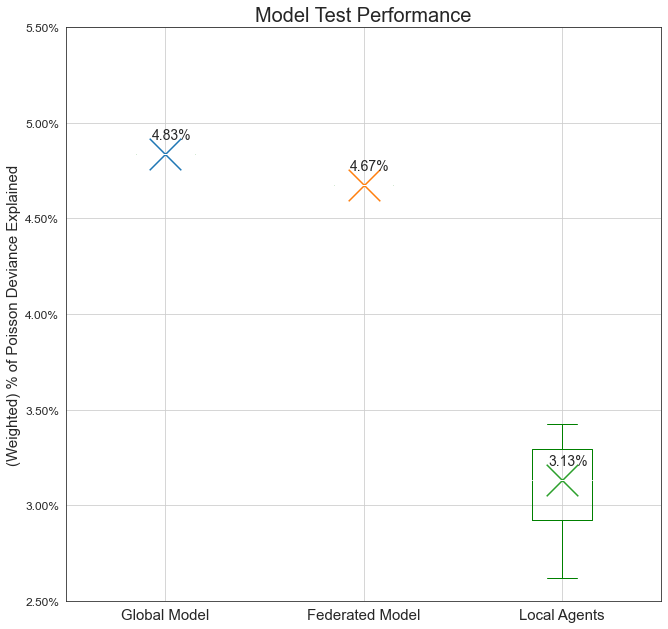

In [239]:
ax = weighted_pde_df_box_plot[['Global Model', 'Federated Model', 'Local Agents']].plot.box(
                                    #vert=False,
                                    #patch_artist=True,
                                    #whis=10
                                    medianprops = dict(linestyle='solid', linewidth=1, color='white'),
                                    boxprops=dict(color='green'),
                                    whiskerprops=dict(color='green'),
                                    flierprops=dict(color='green'),
                                    capprops=dict(color='green')
                                    )
ax.set_title("Model Test Performance", fontsize=20)
ax.set_ylabel('(Weighted) % of Poisson Deviance Explained', fontsize=15)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(bottom=0.025,top=0.055)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.figure.tight_layout()
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
graph_marker='x'
plt.scatter(1, 
            max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Global Model'])
            , marker=graph_marker, 
            s=1000, 
            #facecolors='y', 
            #edgecolors='b'
            )
plt.scatter(2, 
            max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Federated Model'])
            , marker=graph_marker, 
            s=1000, 
            #facecolors='y', 
            #edgecolors='b'
            )
plt.scatter(3, 
            weighted_pde_df_box_plot['Local Agents'].median(),
            marker=graph_marker, 
            s=1000, 
            #facecolors='y', 
            #edgecolors='b'
            )

ax.text(0.93,
        weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Global Model']+0.001, 
       '{:.2%}'.format(max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Global Model'])),
        verticalalignment='center',
        fontdict=(dict(fontsize=14))
        )

ax.text(1.93,
        weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Federated Model']+0.001, 
       '{:.2%}'.format(max(weighted_pde_df['test_weighted_pde'].loc[weighted_pde_df['model']=='Federated Model'])),
        verticalalignment='center',
        fontdict=(dict(fontsize=14))
        )

ax.text(2.93,
        weighted_pde_df_box_plot['Local Agents'].median()+0.001, 
       '{:.2%}'.format(weighted_pde_df_box_plot['Local Agents'].median()),
        verticalalignment='center',
        fontdict=(dict(fontsize=14))
        )

plt.show()


In [240]:
'{:.2%}'.format(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[1:2,1].tolist()[0])

'4.67%'

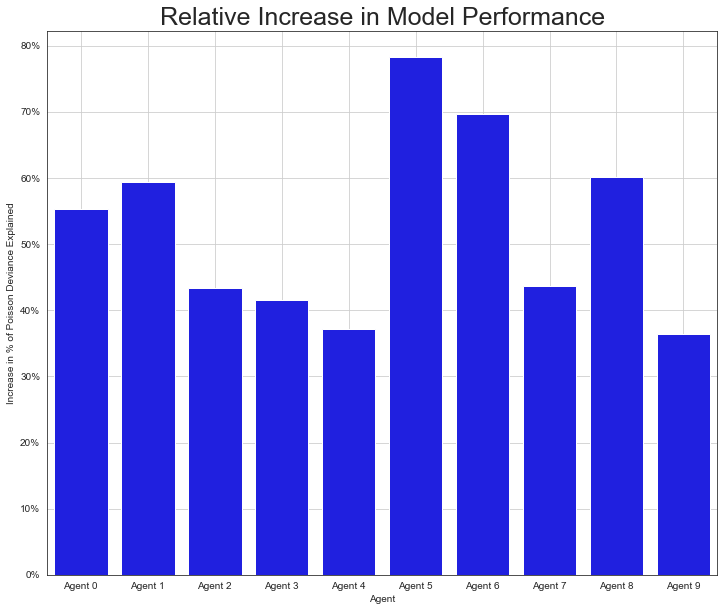

In [241]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(x='model', 
               y='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])],
               #orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

# PDPs

In [ ]:
def plot_partial_dependency(bst, X, y, f_id):

    X_temp = X.copy()

    x_scan = np.linspace(np.percentile(X_temp[:, f_id], 0.1), np.percentile(X_temp[:, f_id], 99.5), 50)
    y_partial = []

    feature =  df_test.columns[f_id]

    for point in x_scan:

        X_temp[:, f_id] = point

        #dpartial = xgb.DMatrix(X_temp[:, feature_ids])

        # Global Model Predictions
        #y_pred = global_model.predict(X_test.astype(np.float64))
        
        #y_partial.append(np.average(bst.predict(X_temp)))
        y_partial.append(np.average(bst.predict(X_temp.astype(np.float64))))

    y_partial = np.array(y_partial)

    # Plot partial dependence

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(x_scan, y_partial, '-', color = 'black', linewidth = 1)
    #ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)

    ax.set_xlim(min(x_scan), max(x_scan))
    ax.set_xlabel(feature, fontsize = 12)    
    ax.set_ylabel('Partial Dependence', fontsize = 12)

    #plt.title(bst, fontsize=25)

    ax.grid(True)
    
    plt.show()

Feature 0


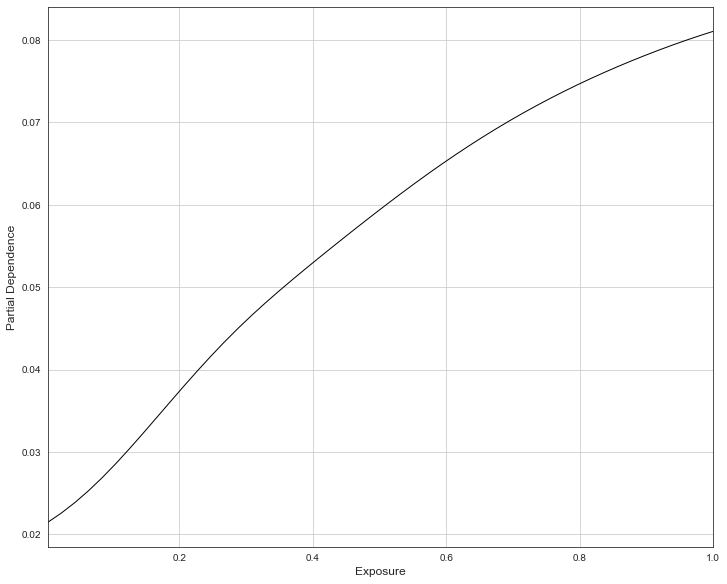

Feature 1


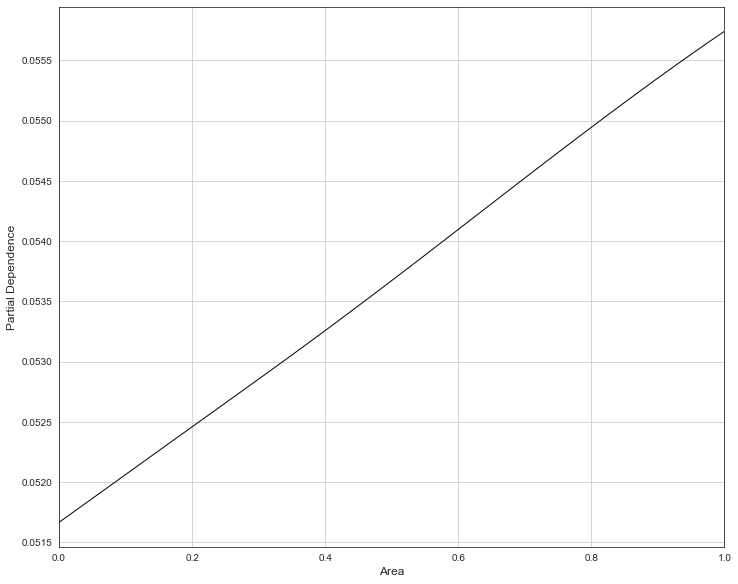

Feature 2


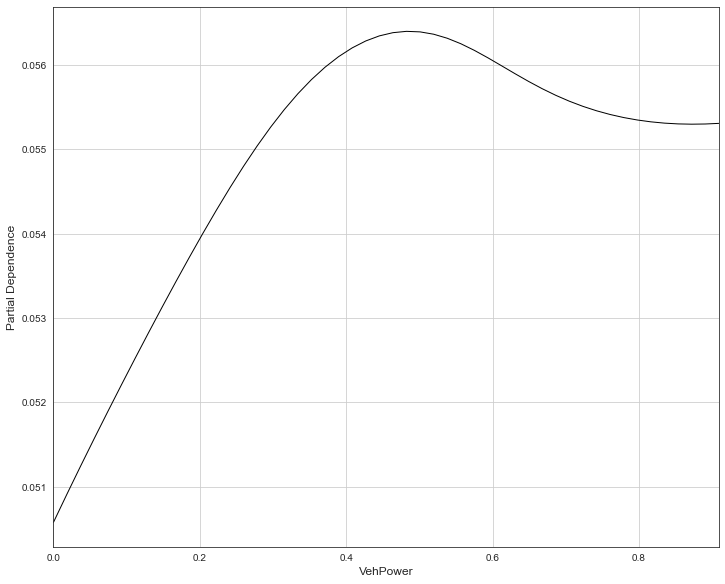

Feature 3


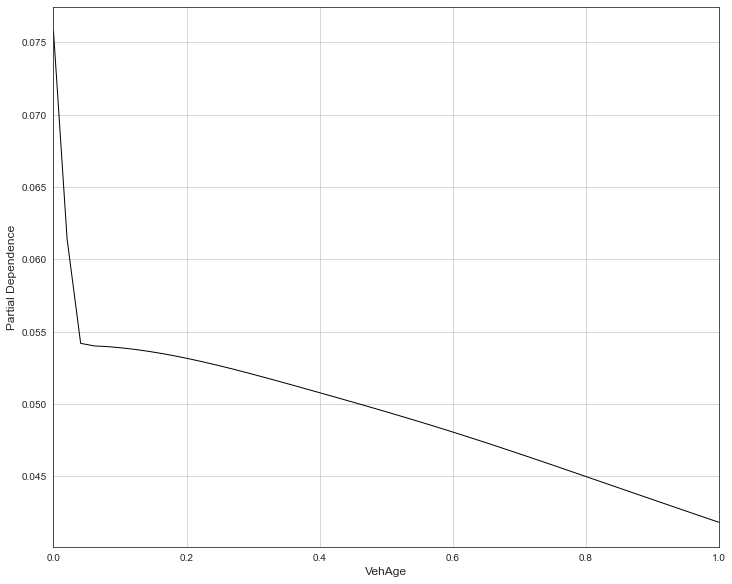

Feature 4


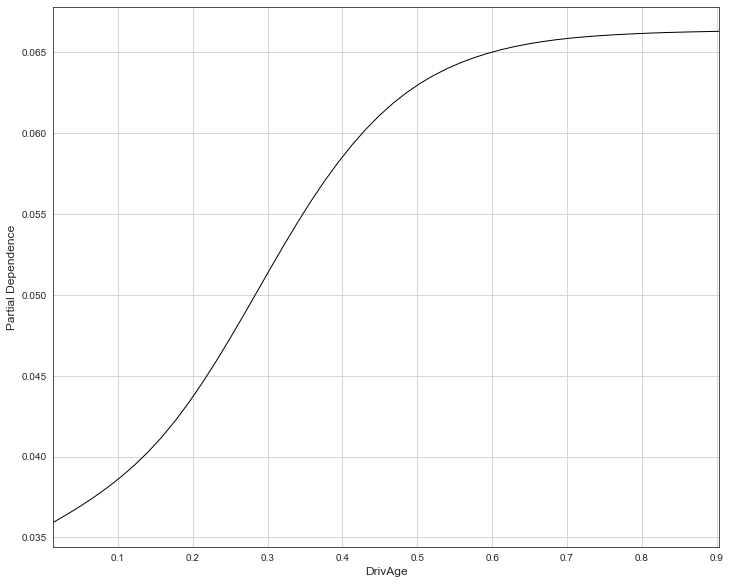

Feature 5


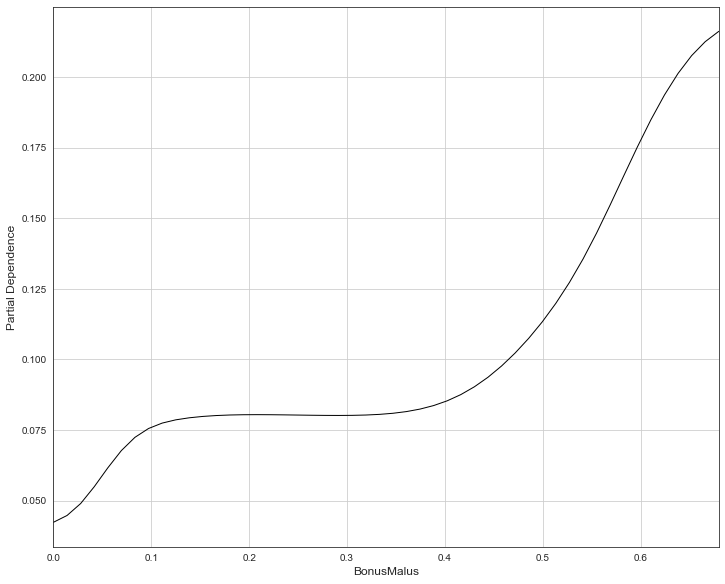

Feature 6


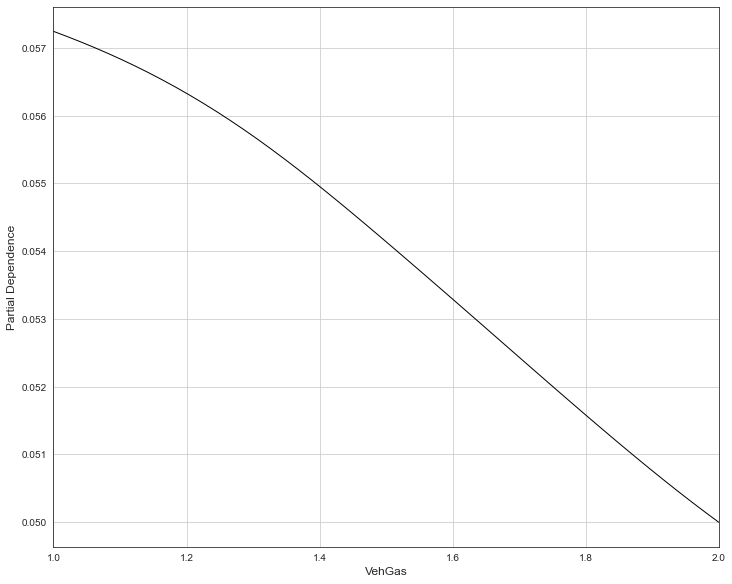

Feature 7


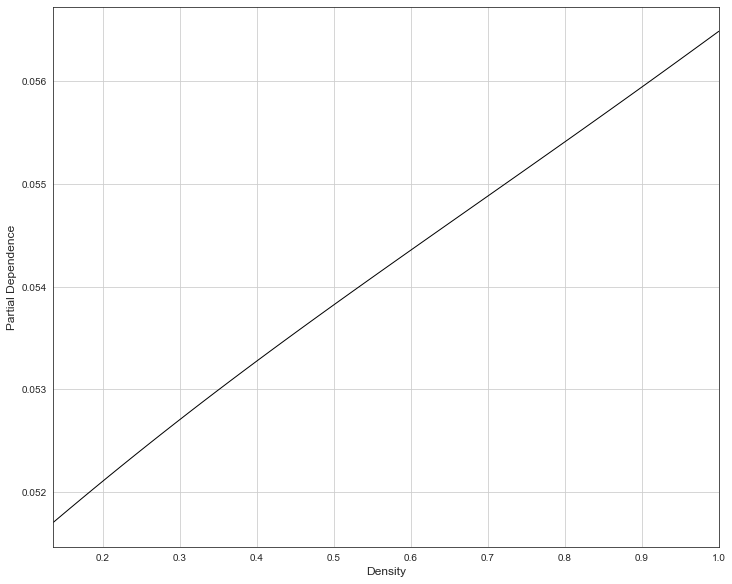

In [ ]:
for i in range(0,8):
    print('Feature '+str(i))
    plot_partial_dependency(loaded_agent_global_model, X_test, y_test, i)

Feature 0
Agent 0


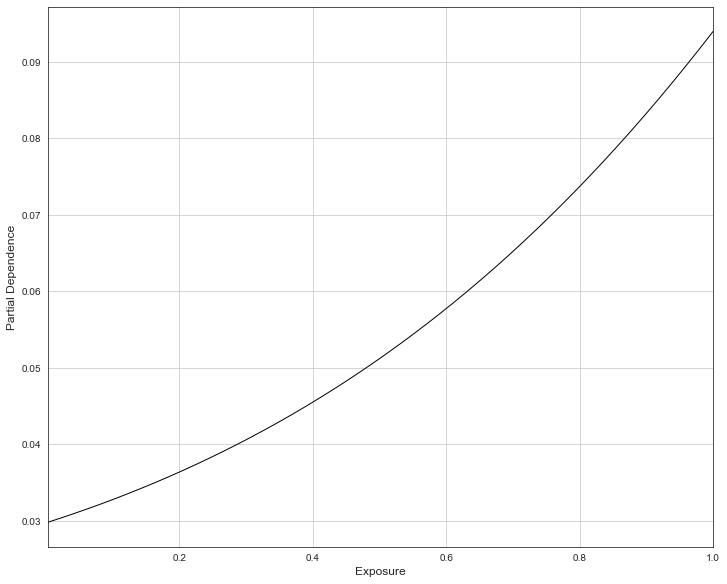

Agent 1


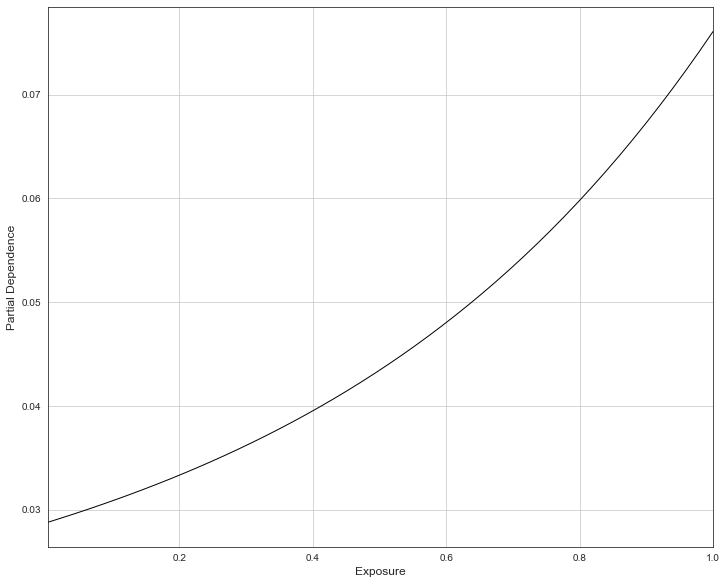

Agent 2


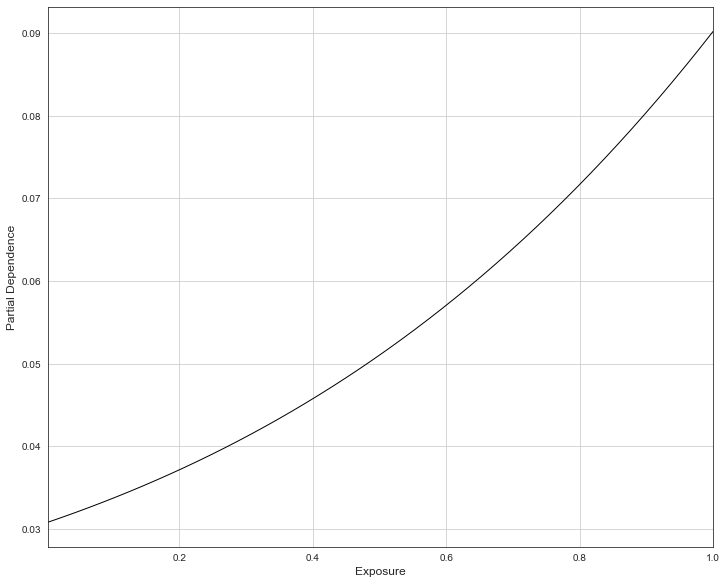

Agent 3


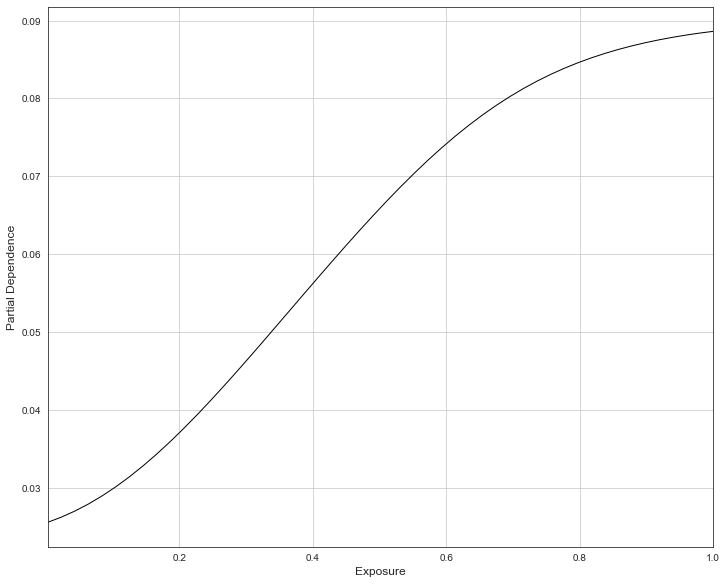

Agent 4


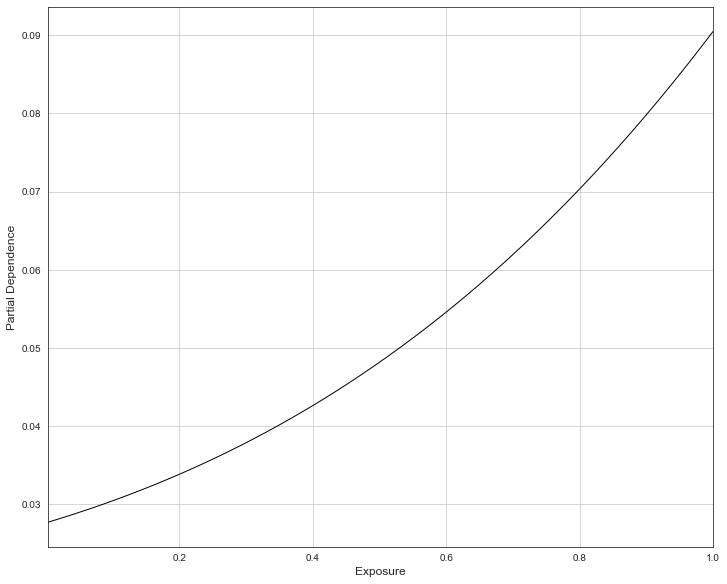

Agent 5


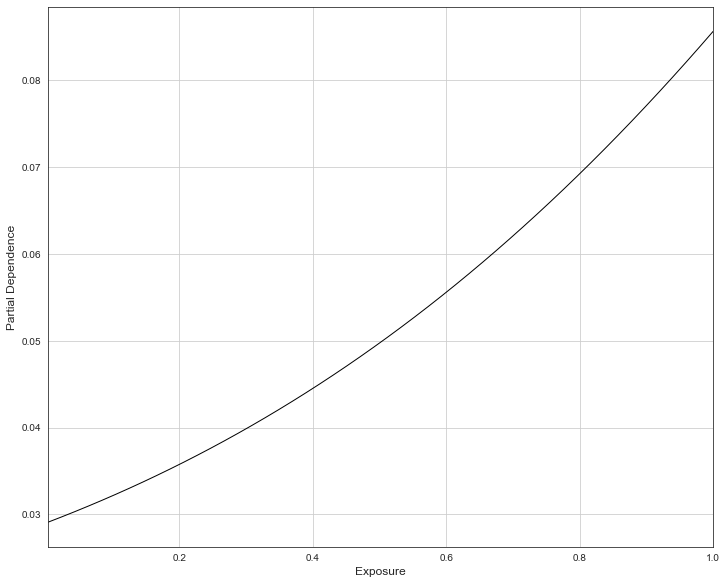

Agent 6


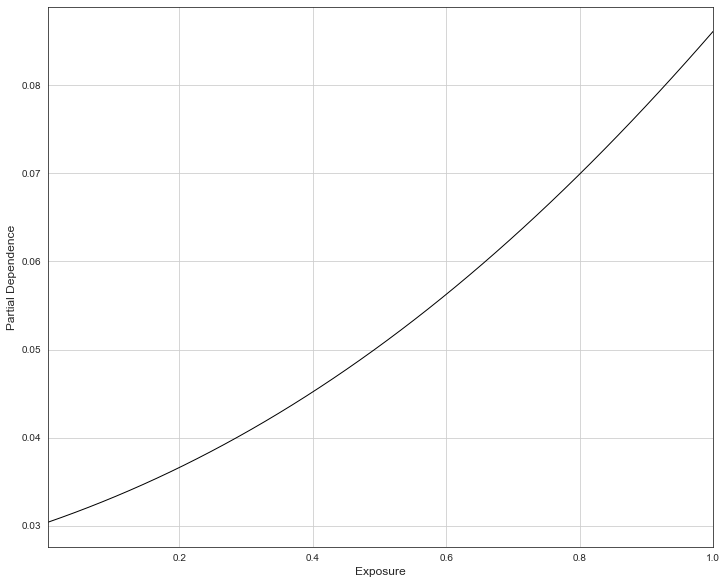

Agent 7


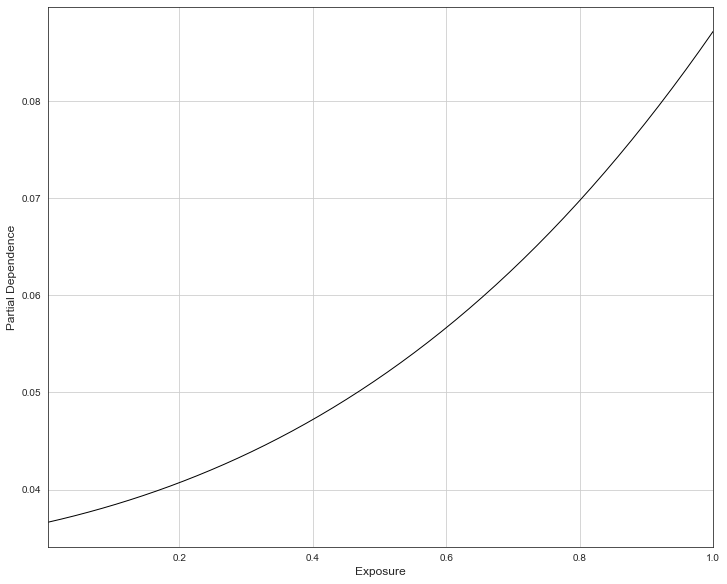

Agent 8


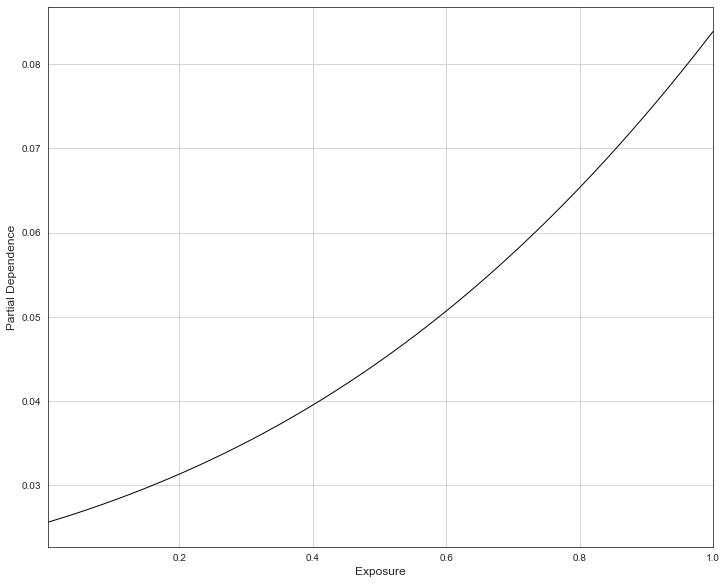

Agent 9


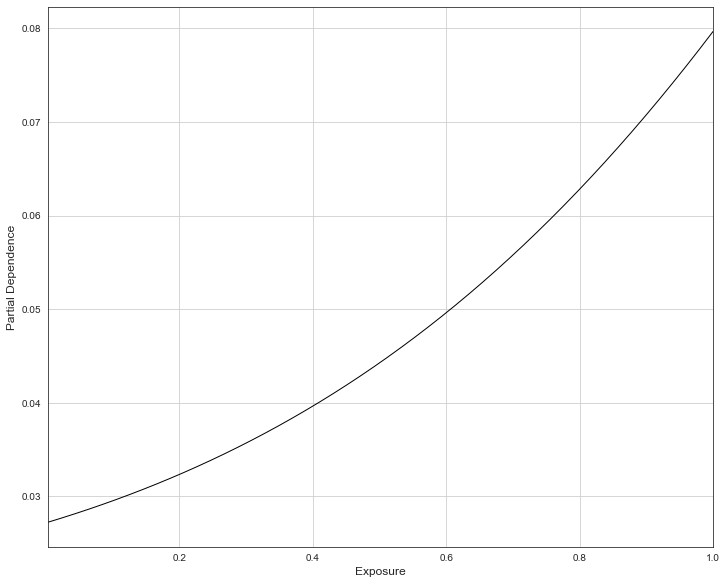

Feature 1
Agent 0


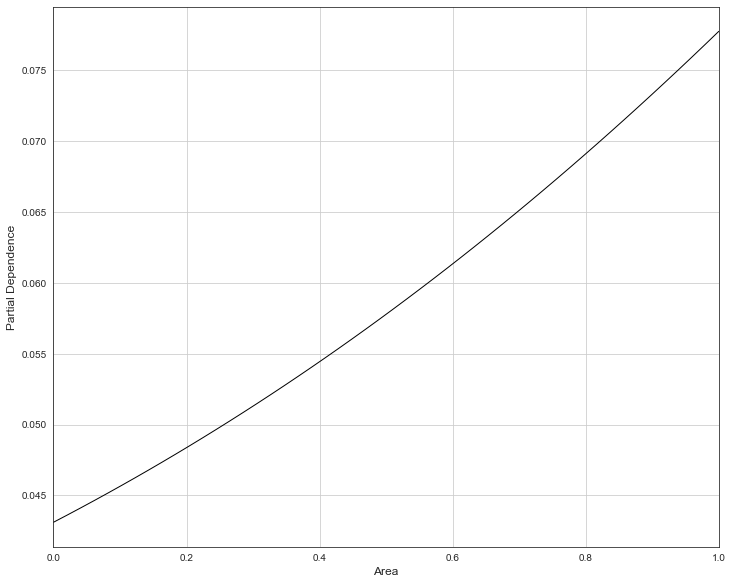

Agent 1


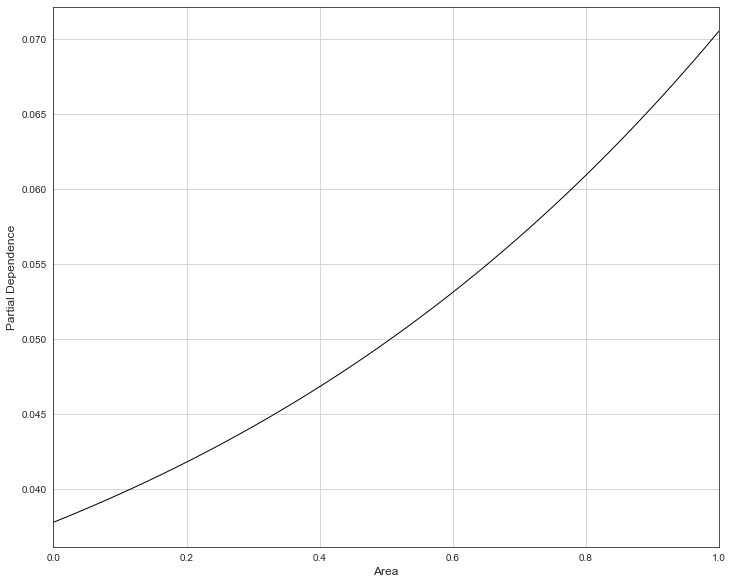

Agent 2


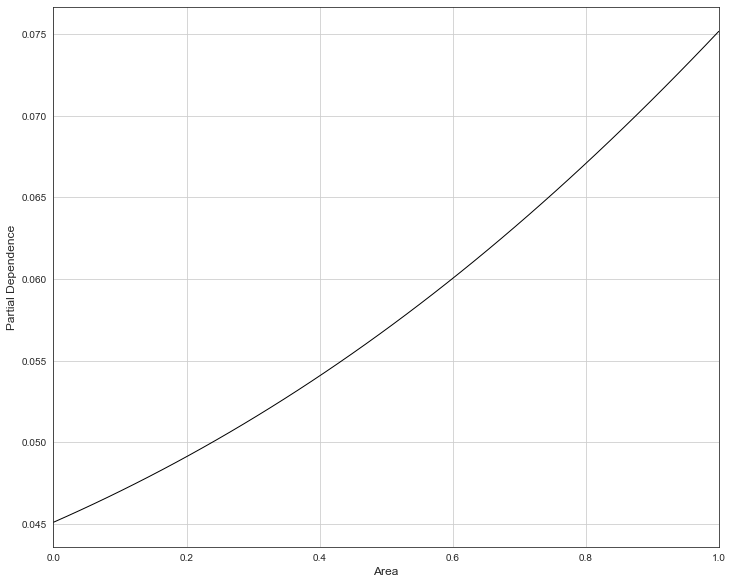

Agent 3


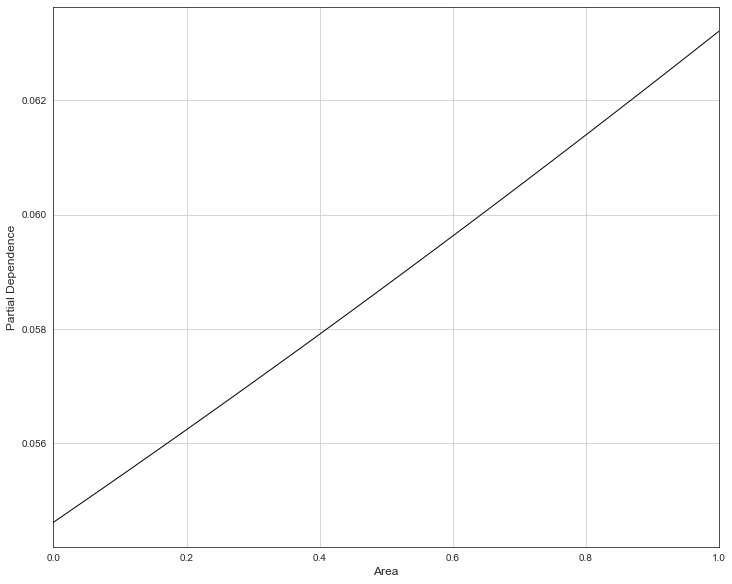

Agent 4


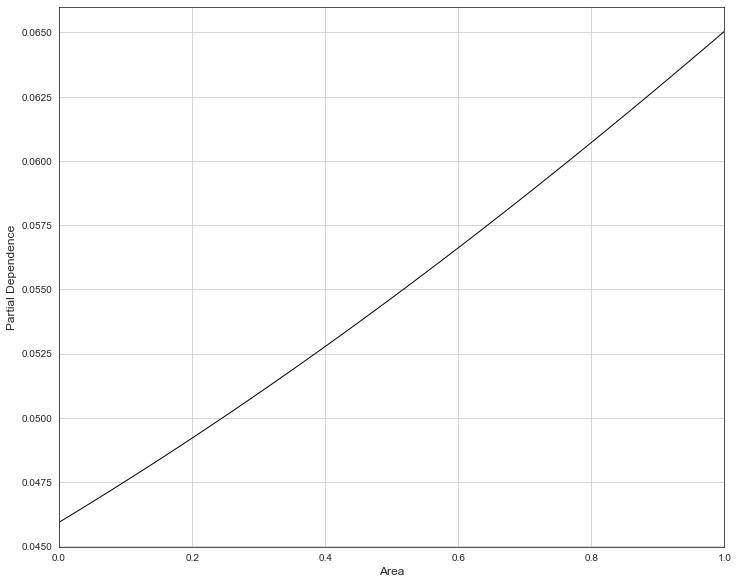

Agent 5


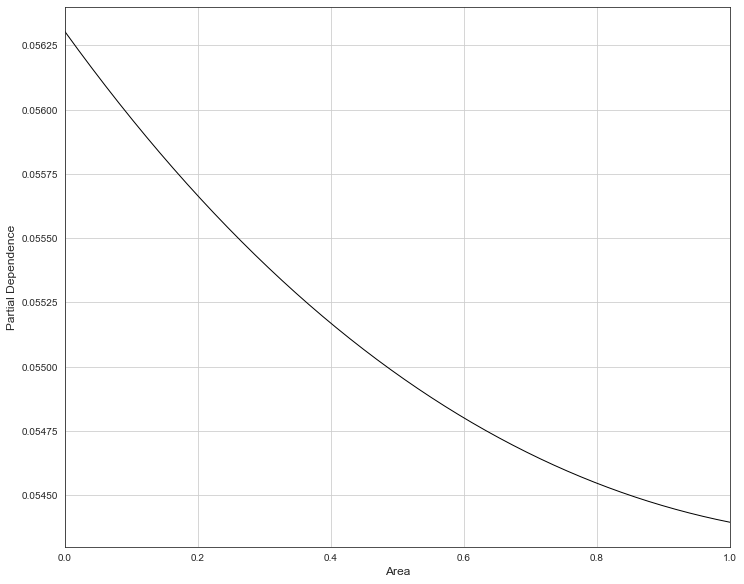

Agent 6


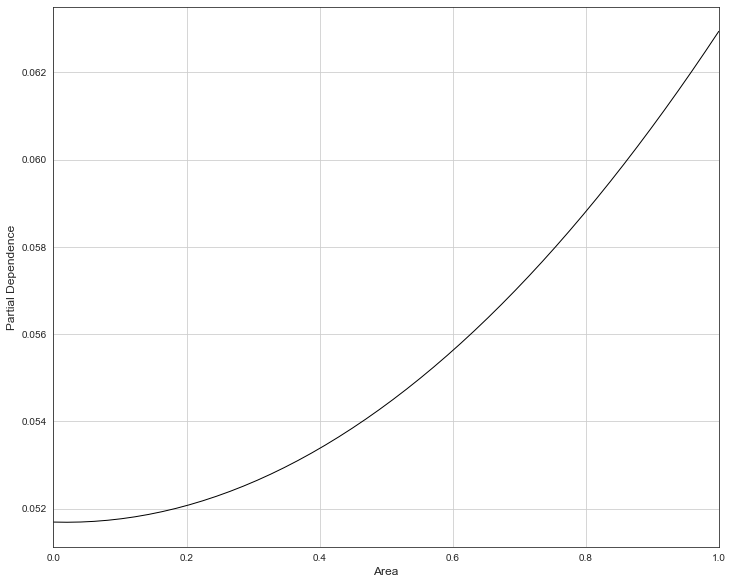

Agent 7


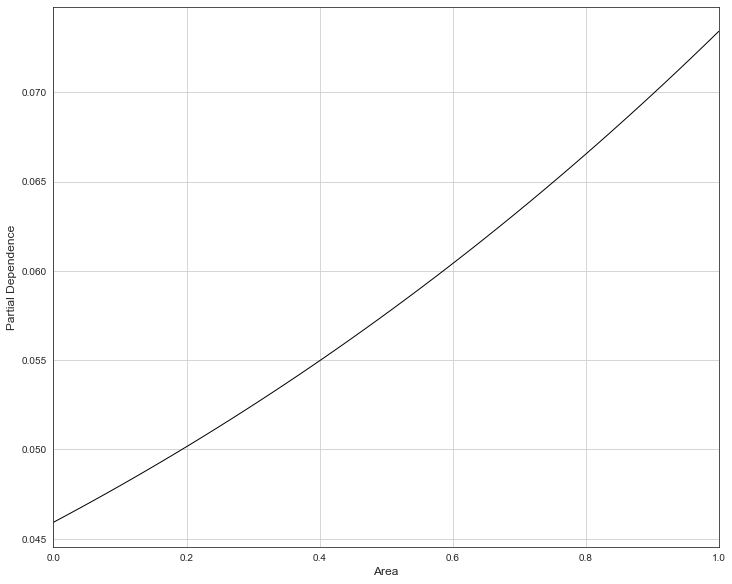

Agent 8


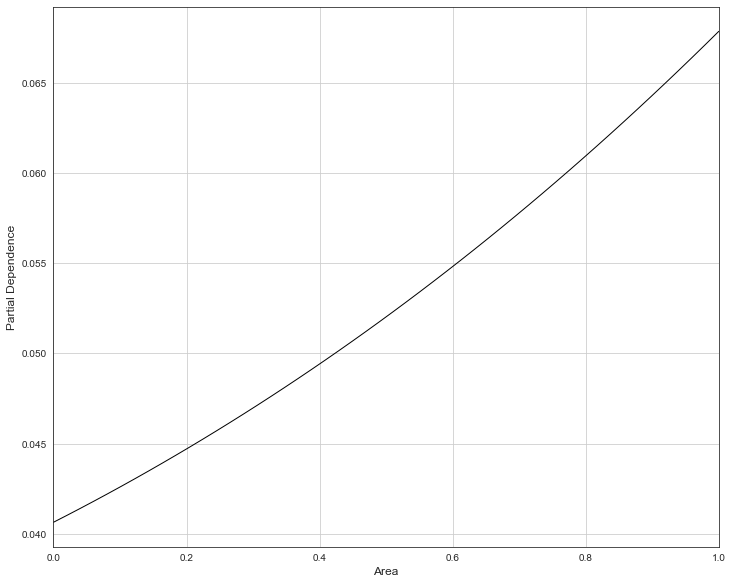

Agent 9


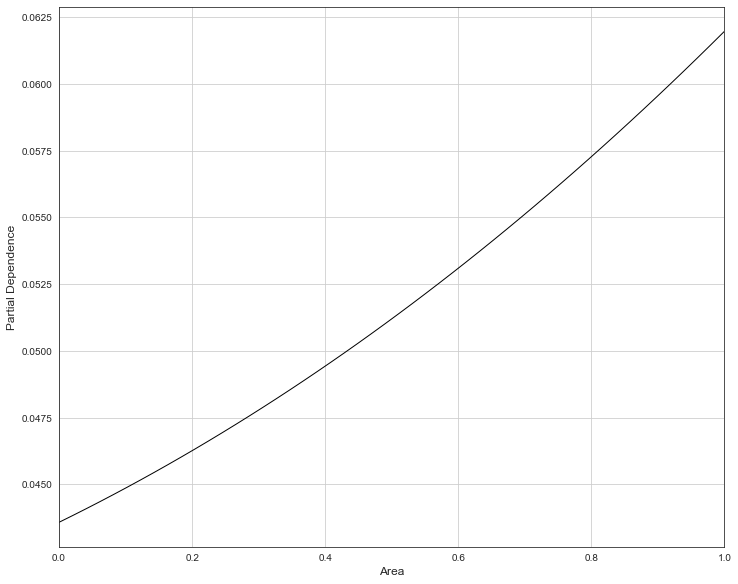

Feature 2
Agent 0


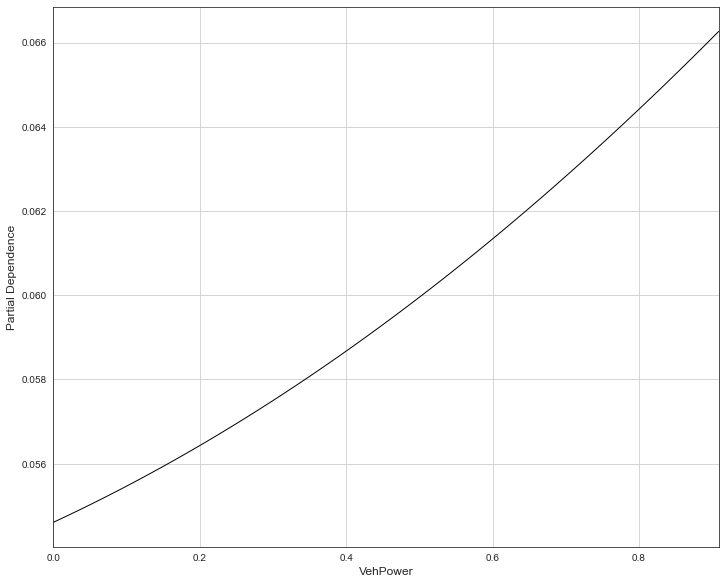

Agent 1


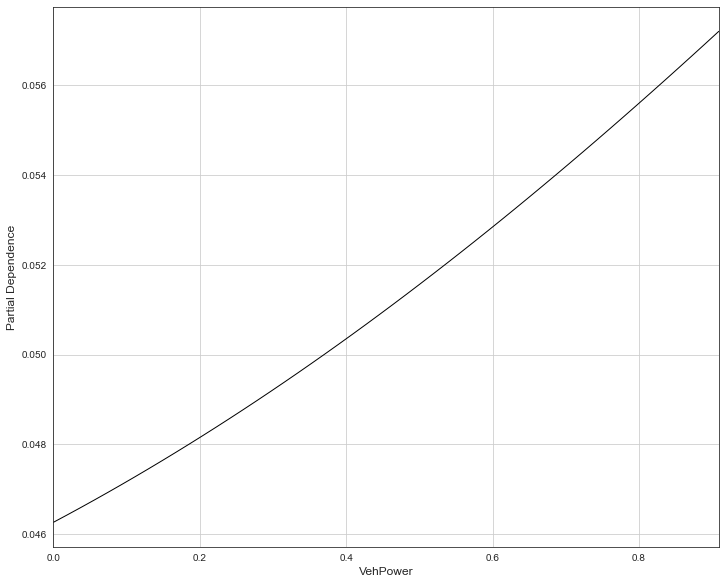

Agent 2


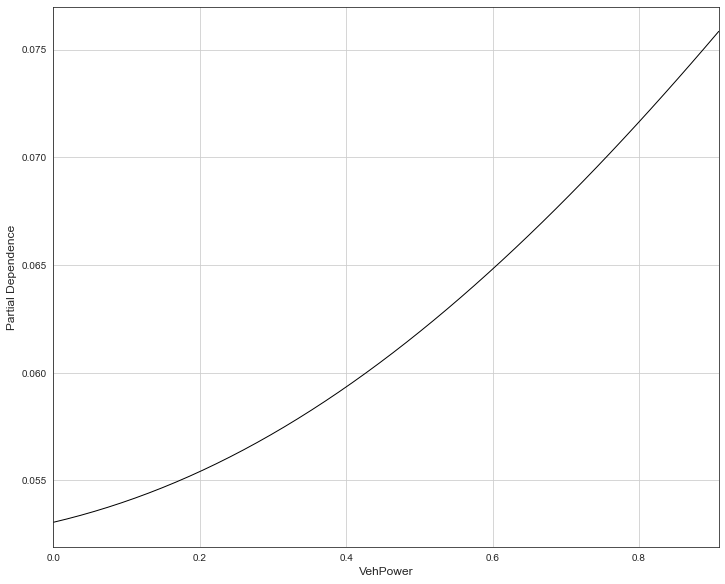

Agent 3


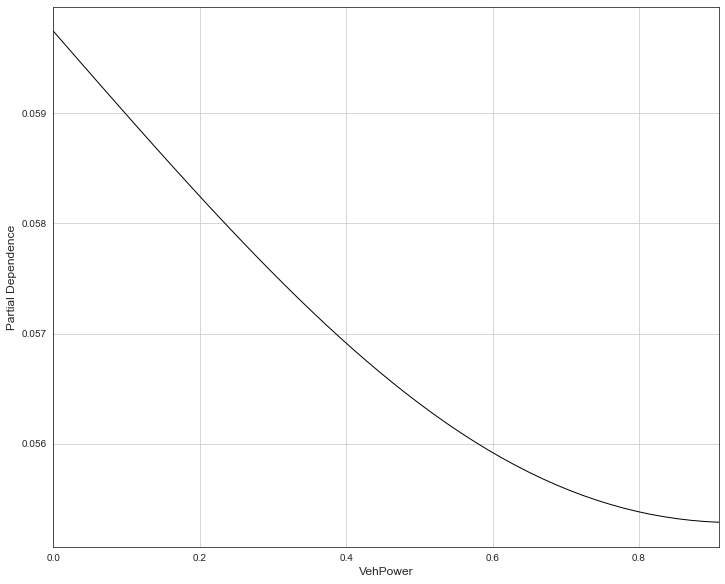

Agent 4


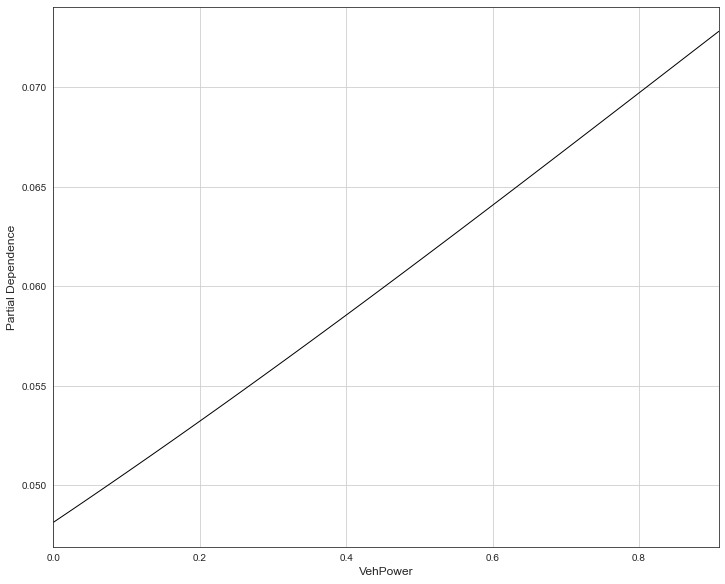

Agent 5


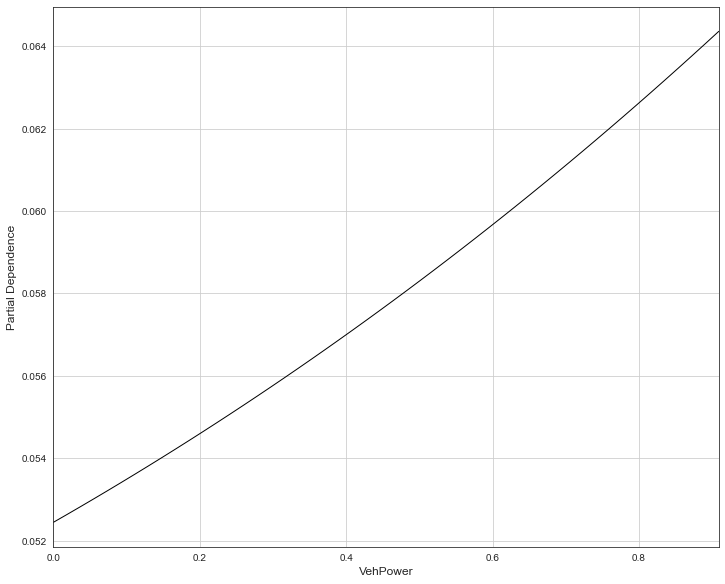

Agent 6


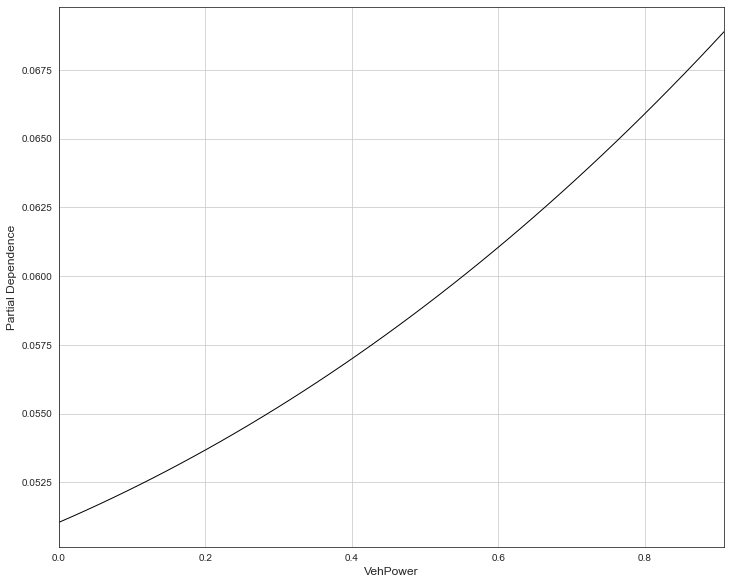

Agent 7


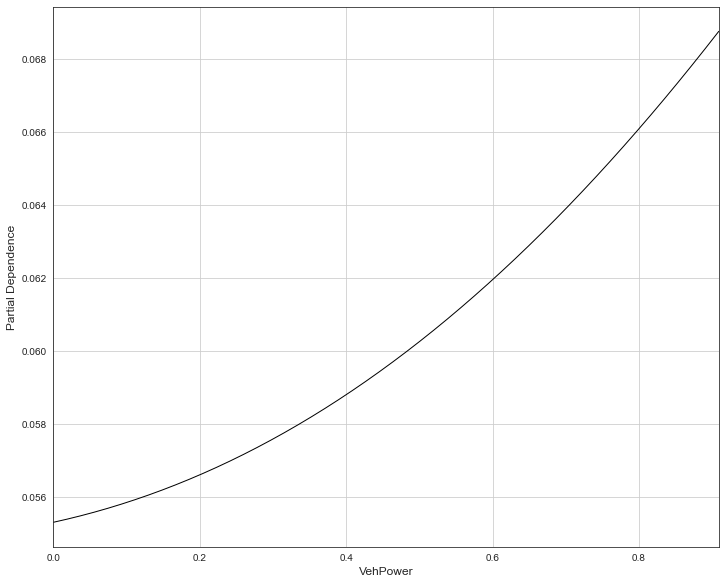

Agent 8


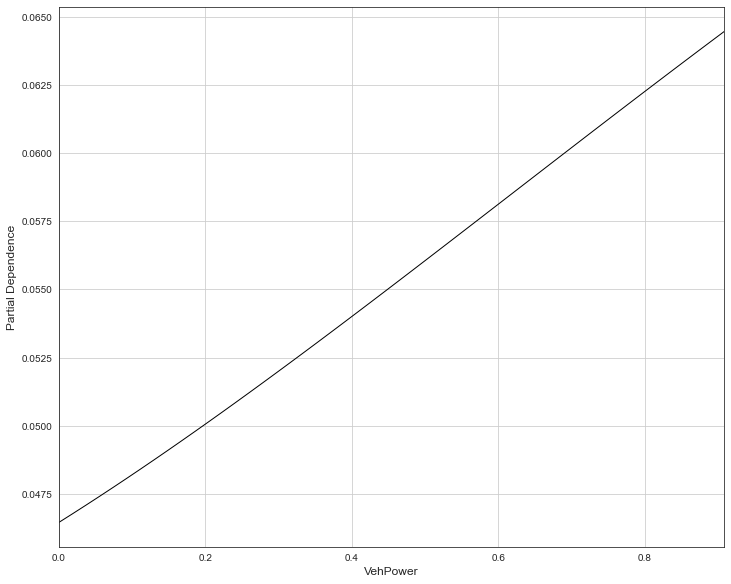

Agent 9


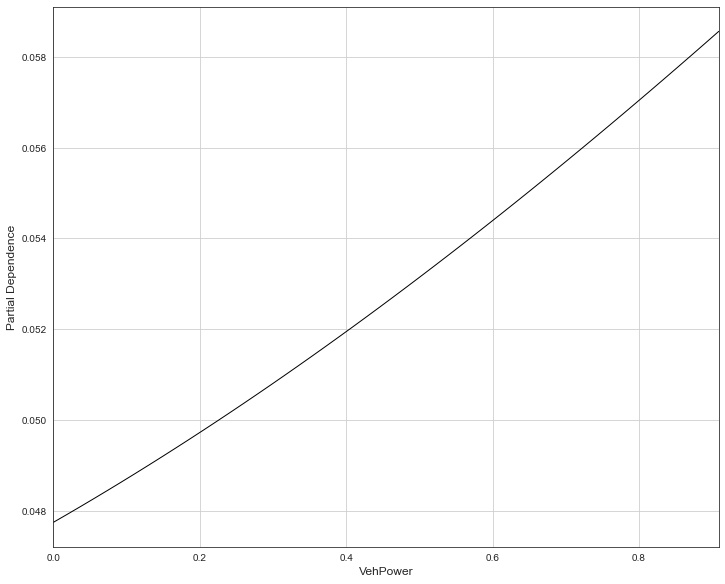

Feature 3
Agent 0


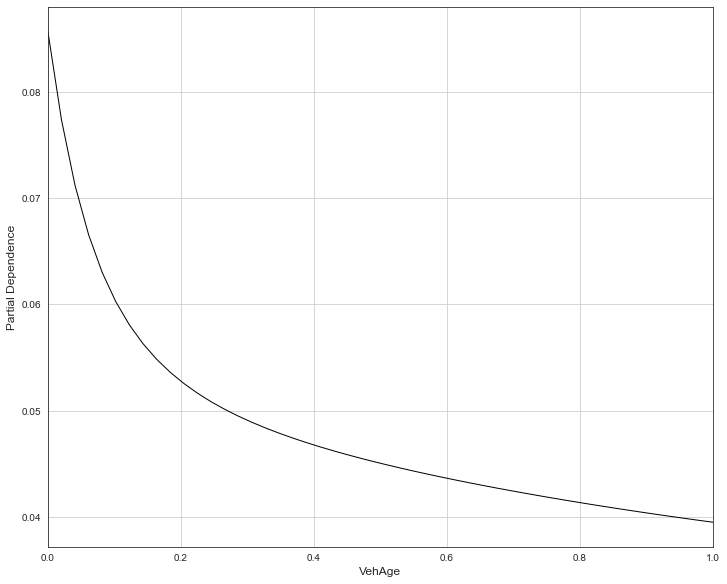

Agent 1


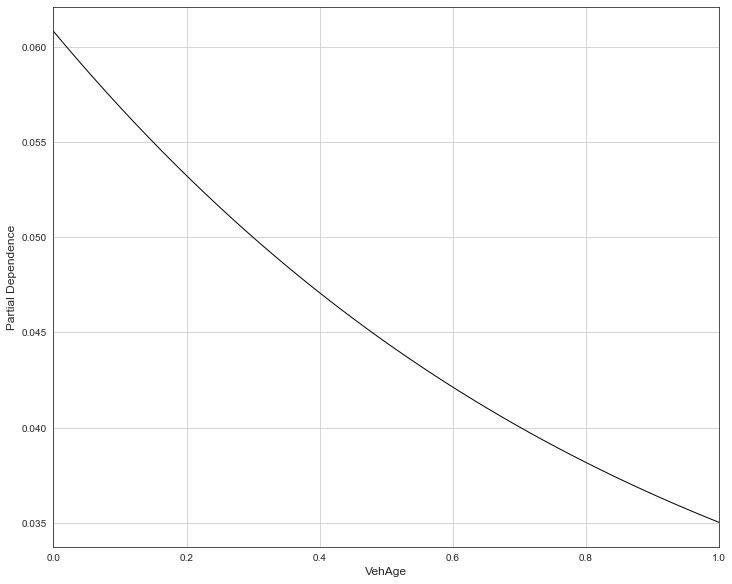

Agent 2


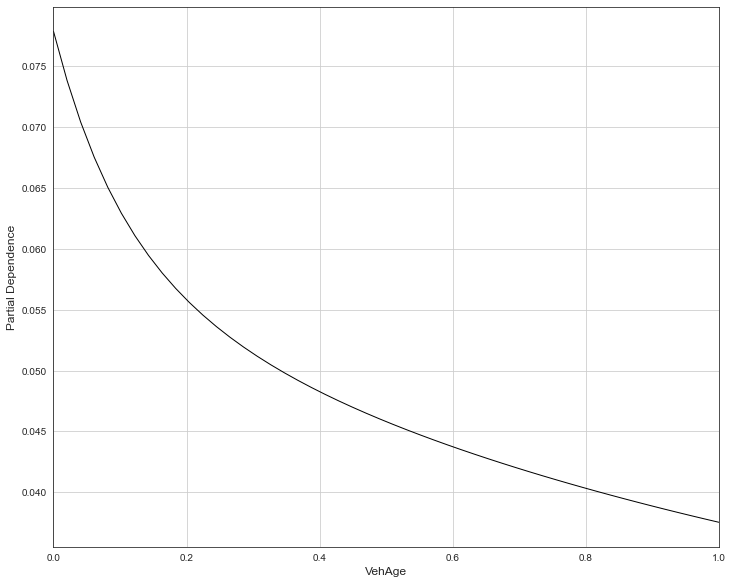

Agent 3


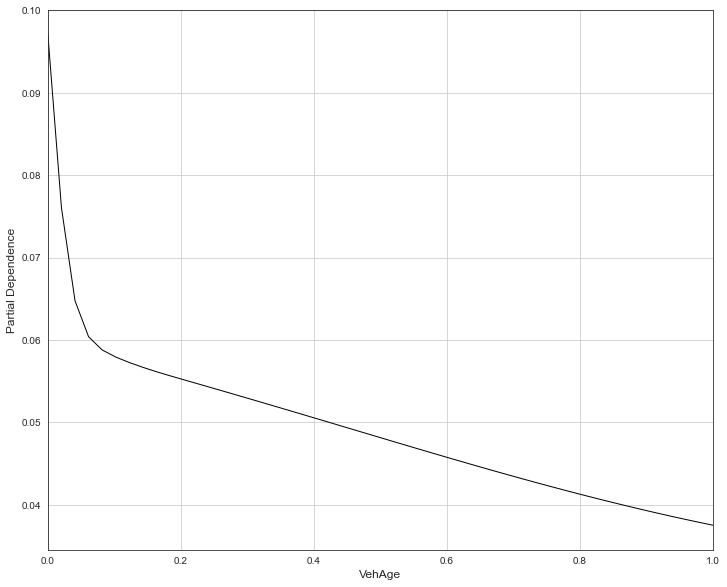

Agent 4


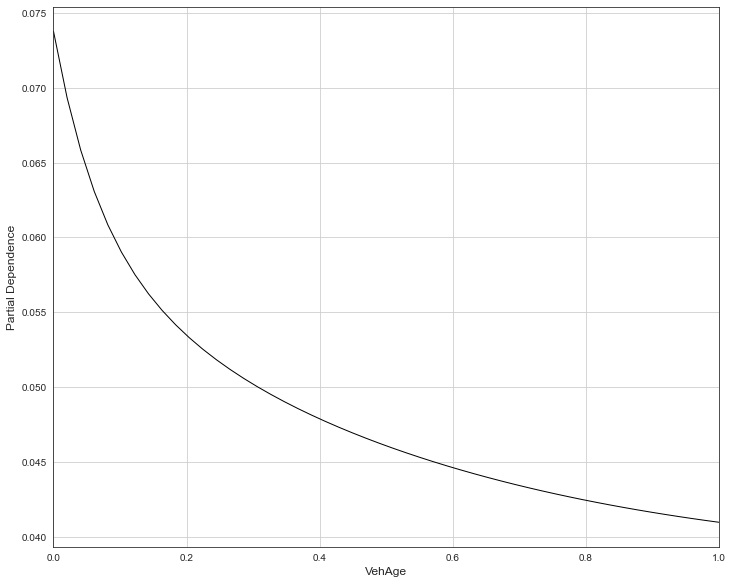

Agent 5


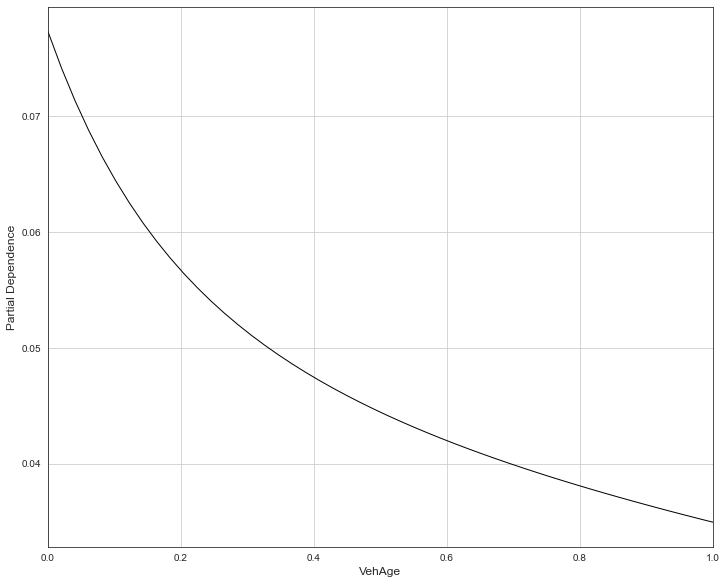

Agent 6


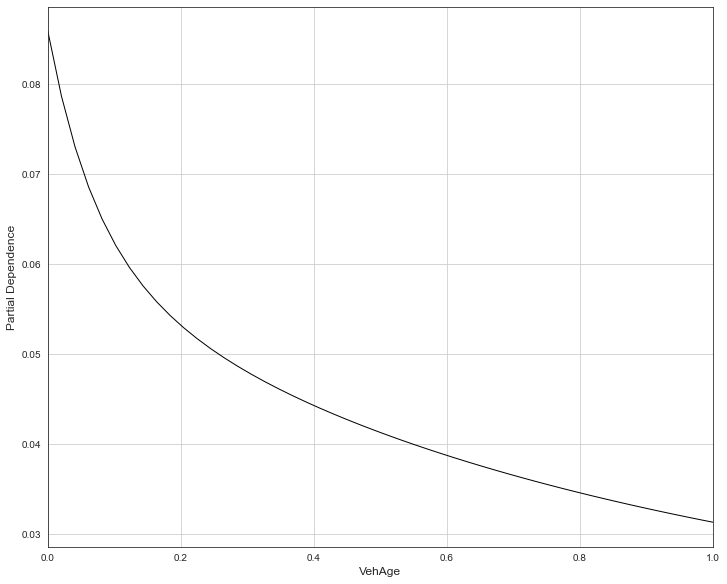

Agent 7


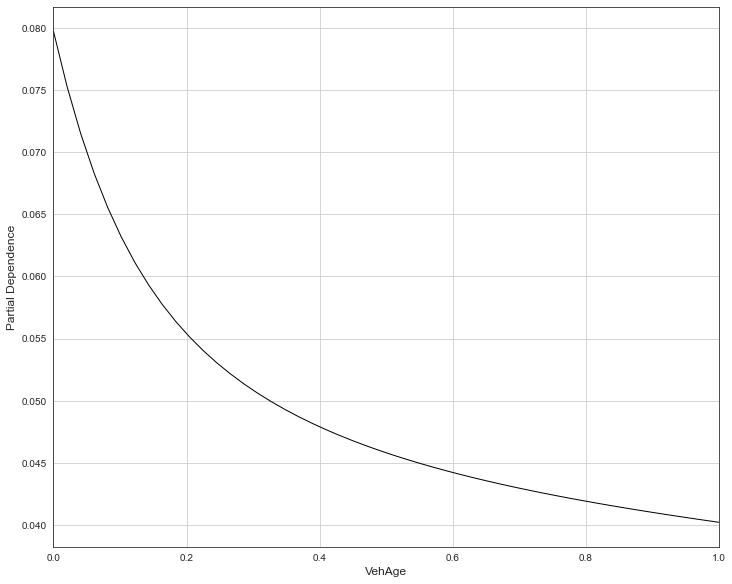

Agent 8


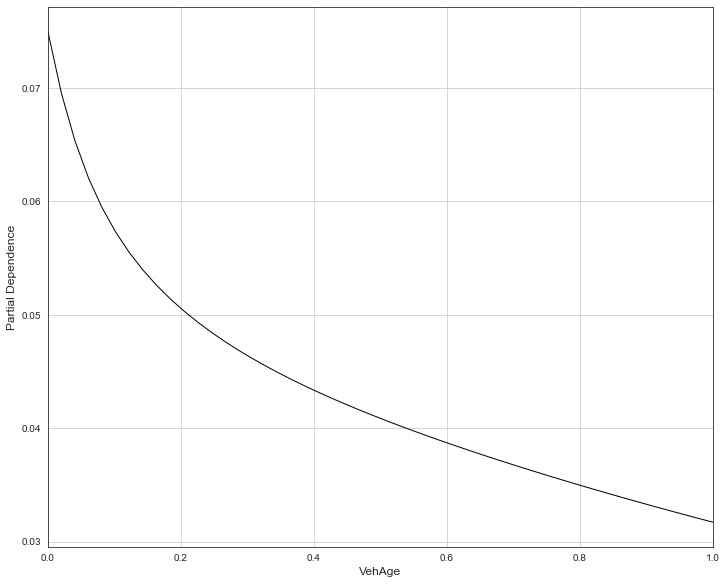

Agent 9


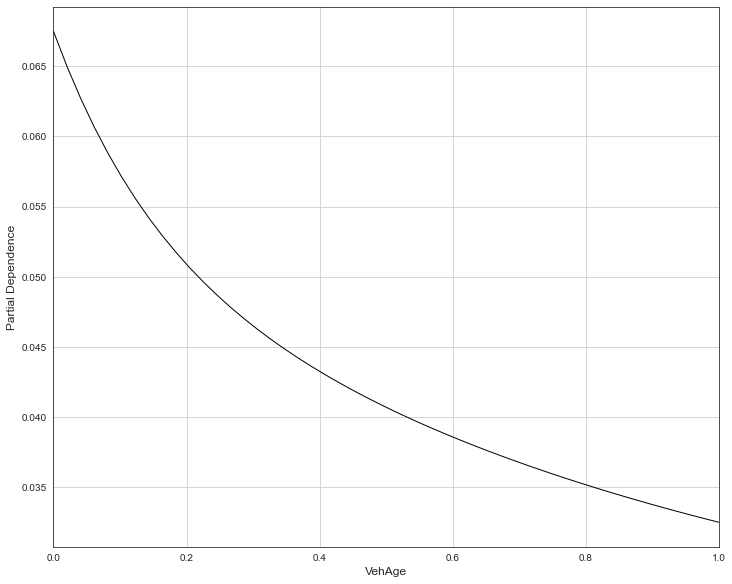

Feature 4
Agent 0


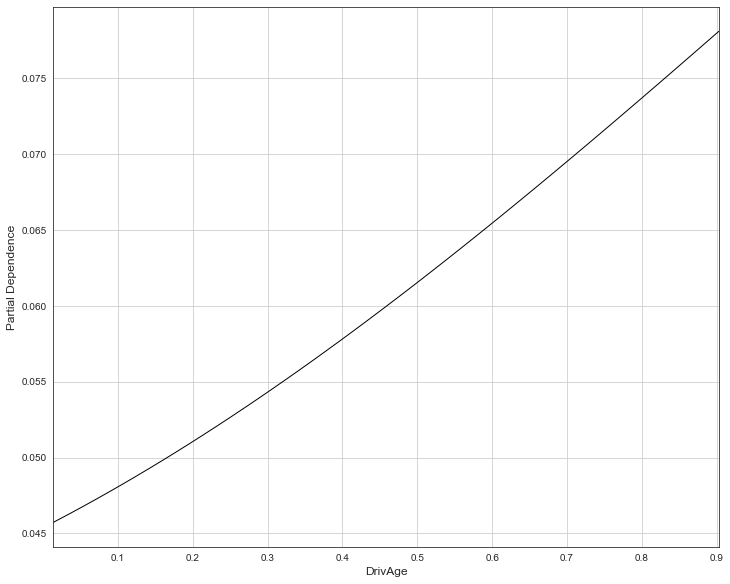

Agent 1


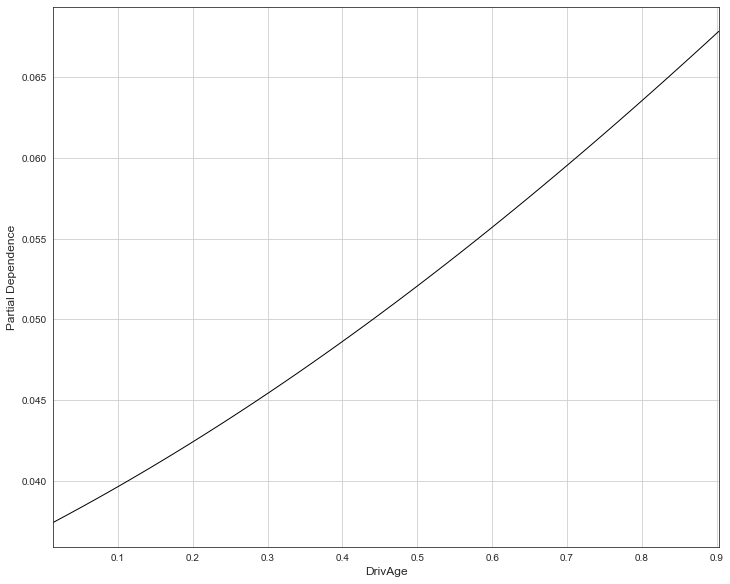

Agent 2


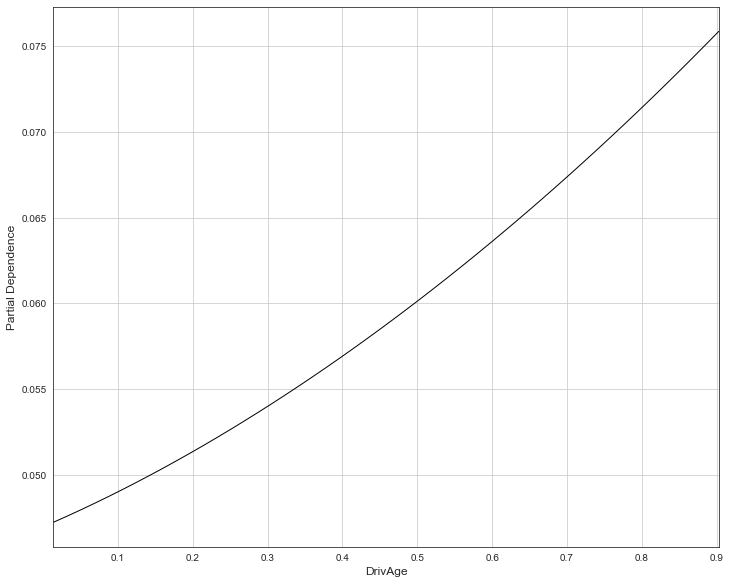

Agent 3


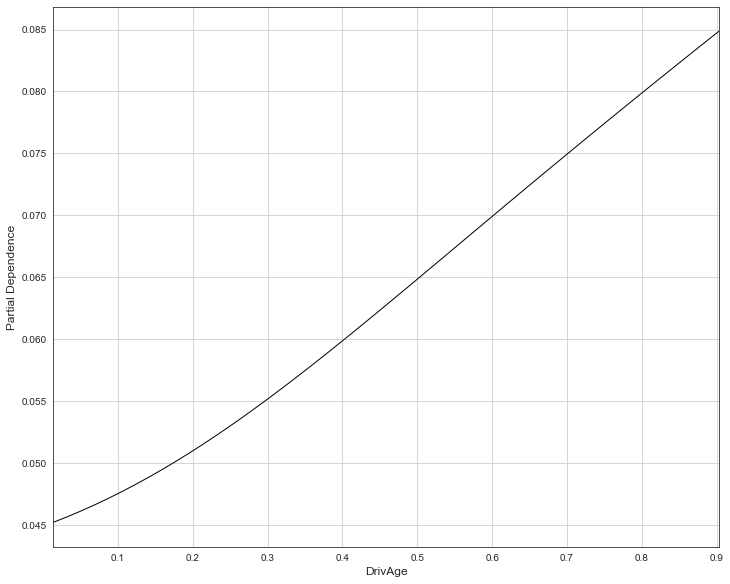

Agent 4


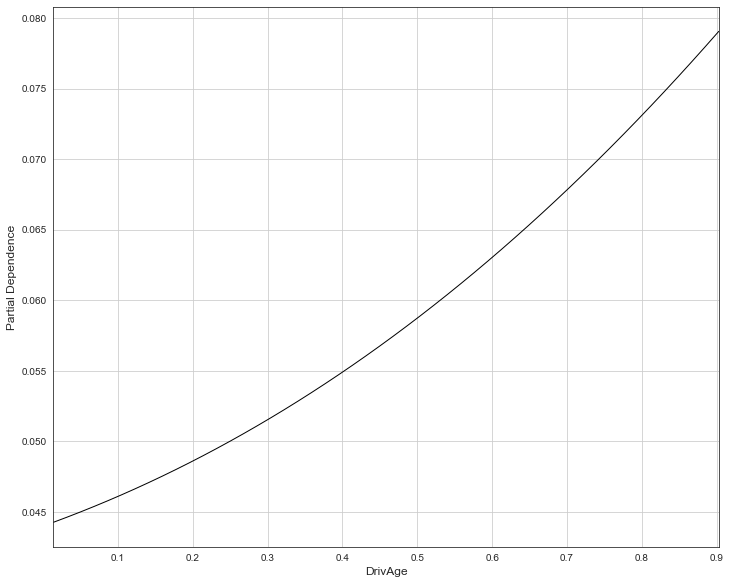

Agent 5


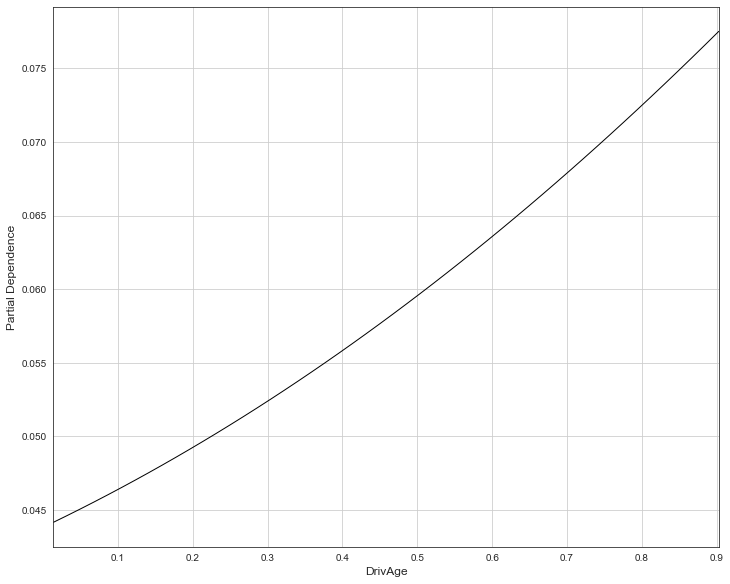

Agent 6


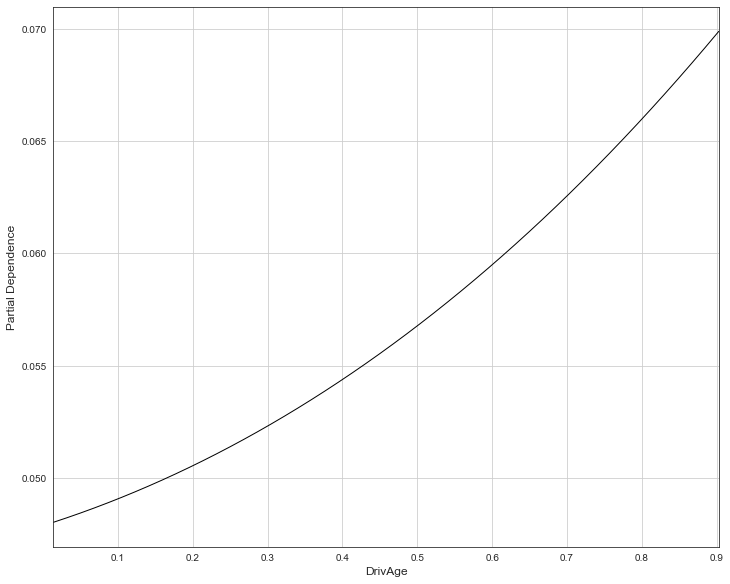

Agent 7


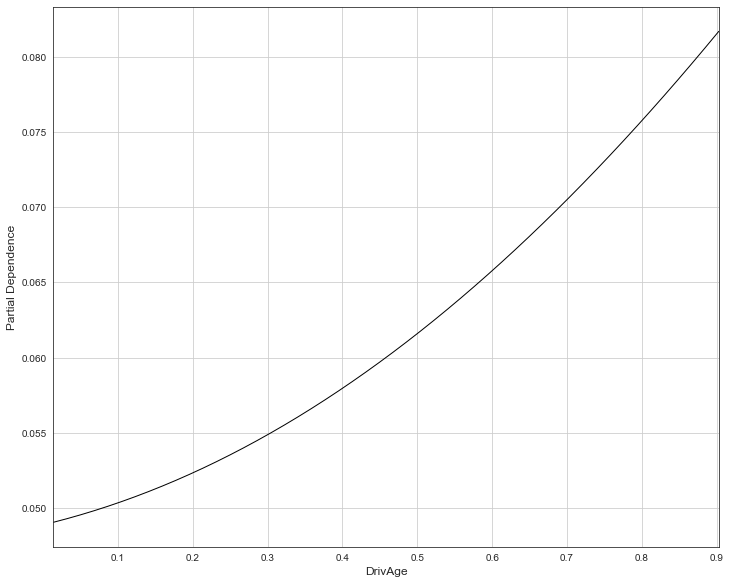

Agent 8


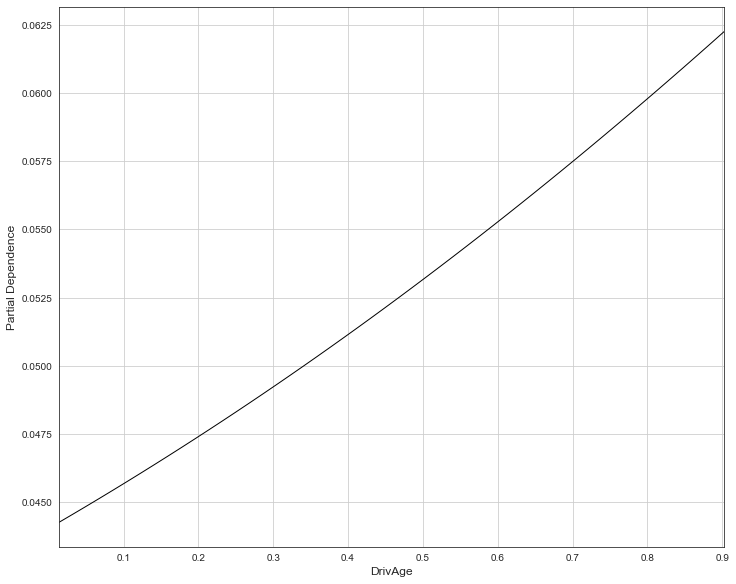

Agent 9


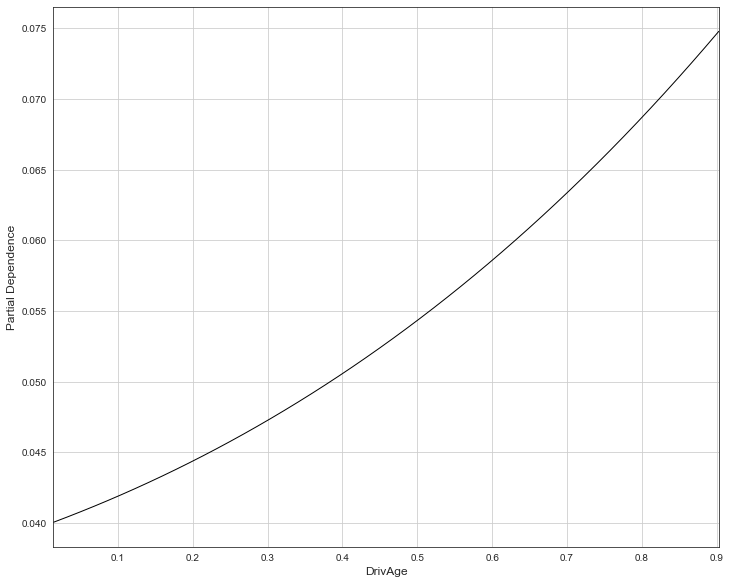

Feature 5
Agent 0


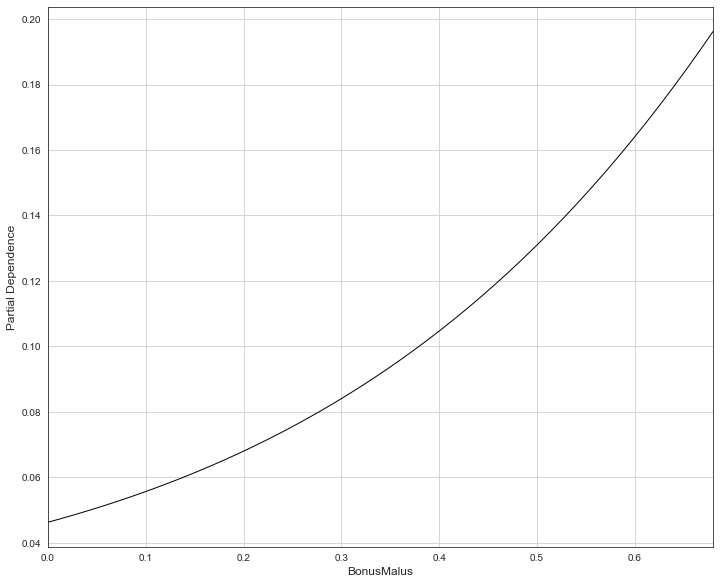

Agent 1


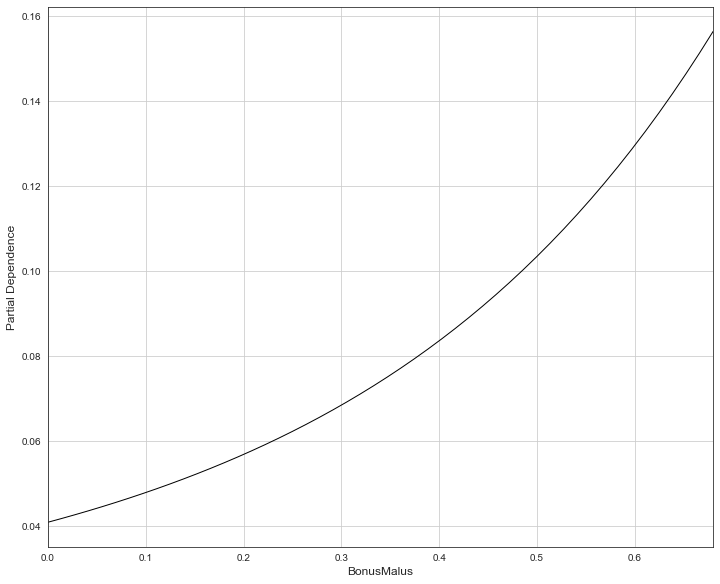

Agent 2


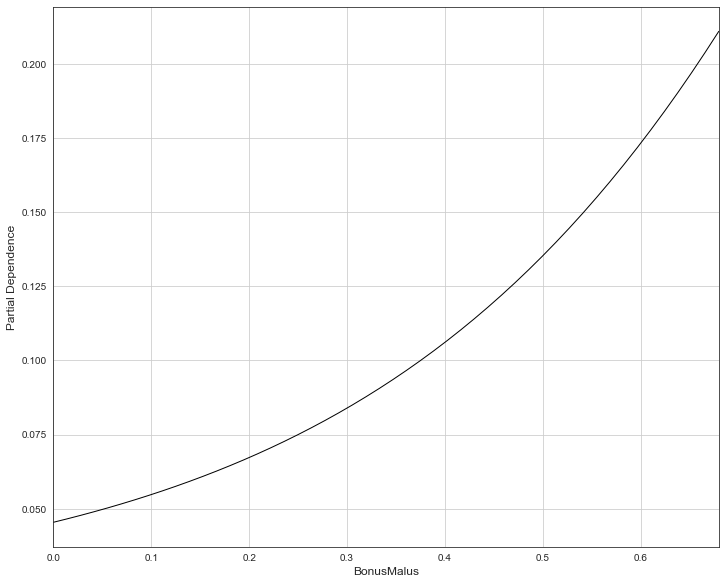

Agent 3


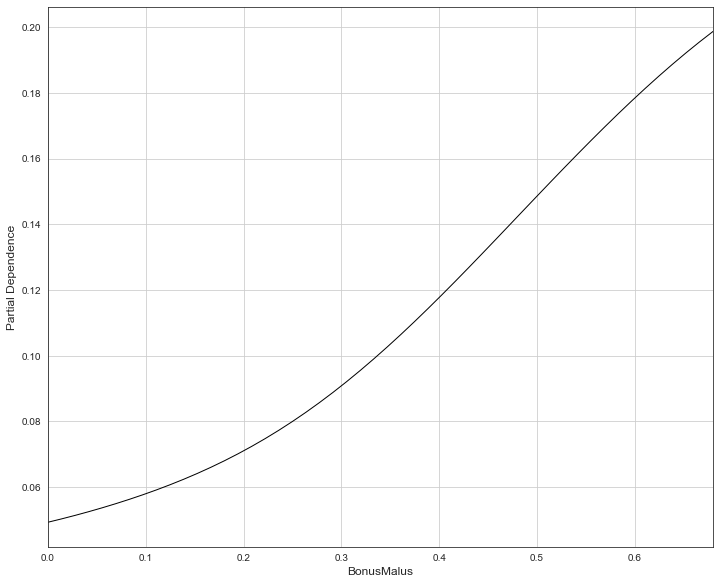

Agent 4


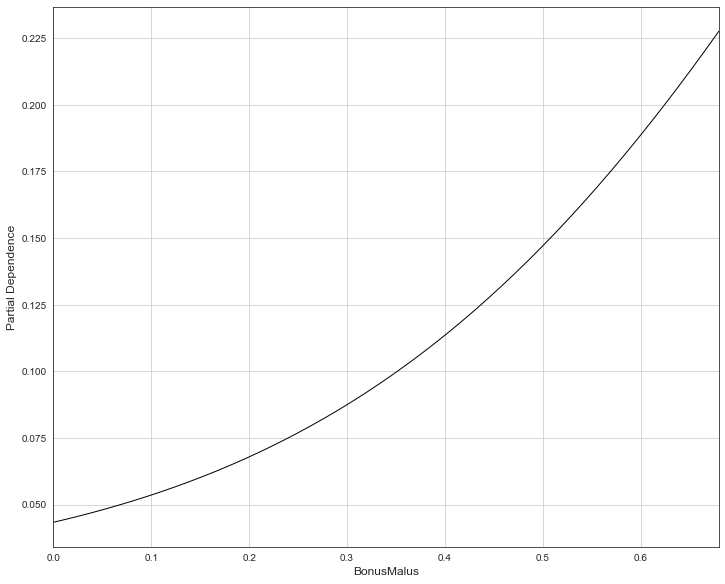

Agent 5


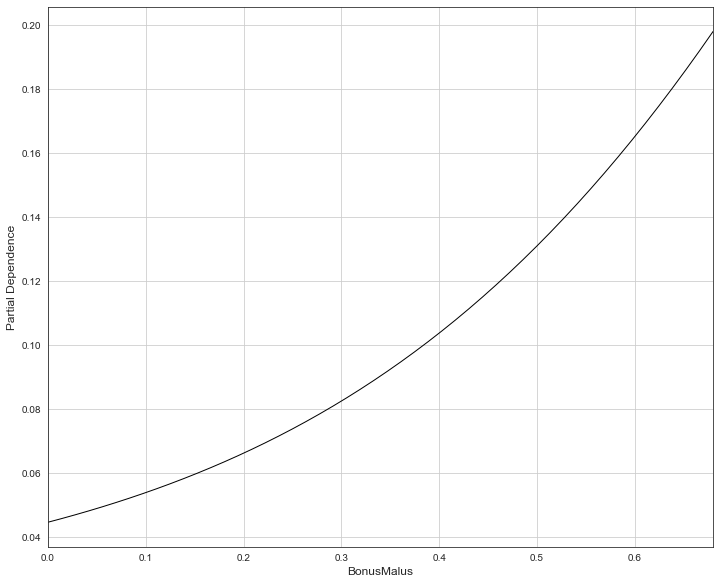

Agent 6


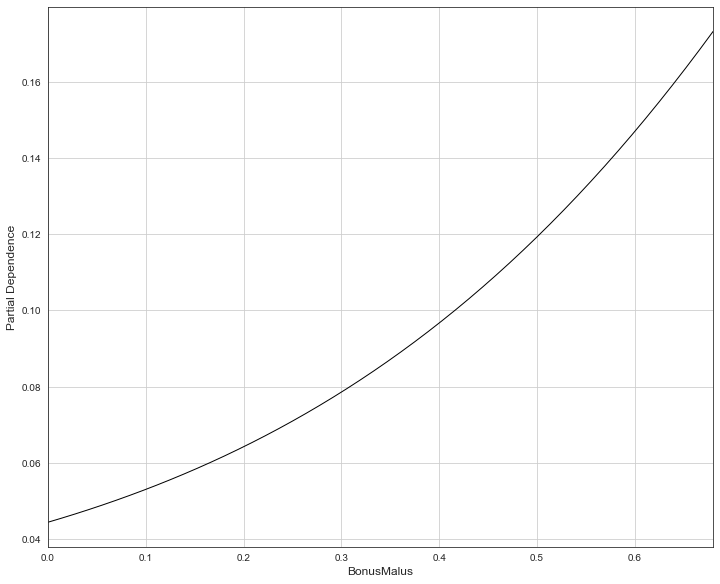

Agent 7


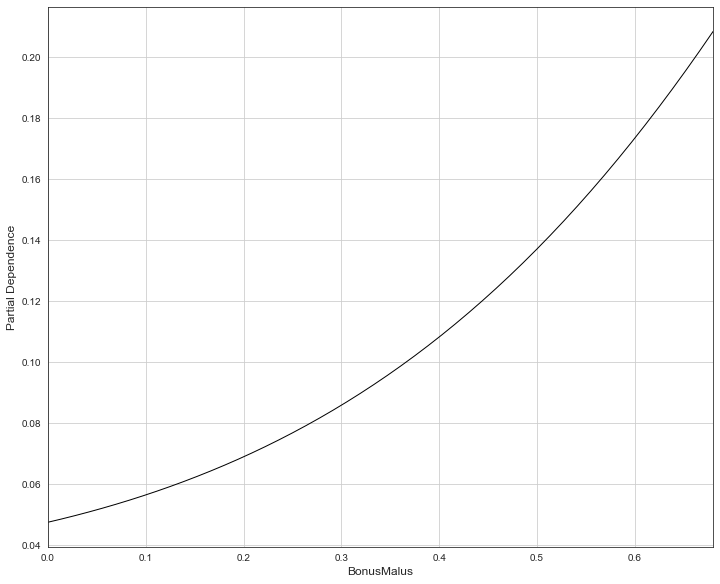

Agent 8


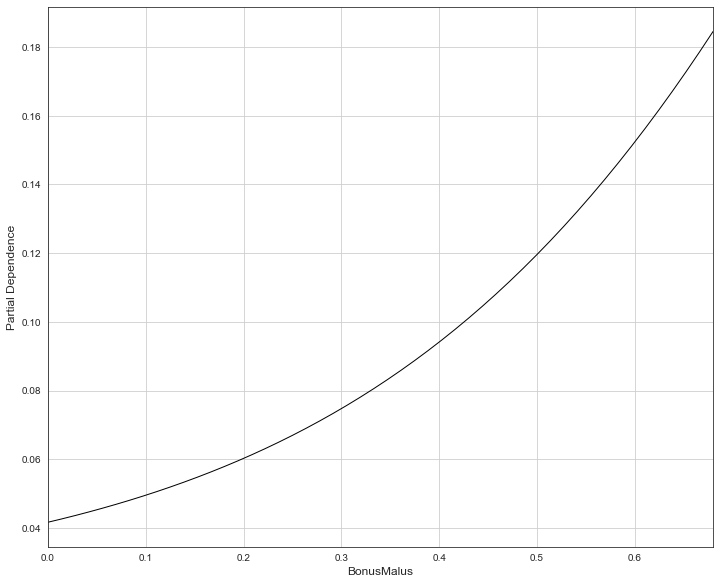

Agent 9


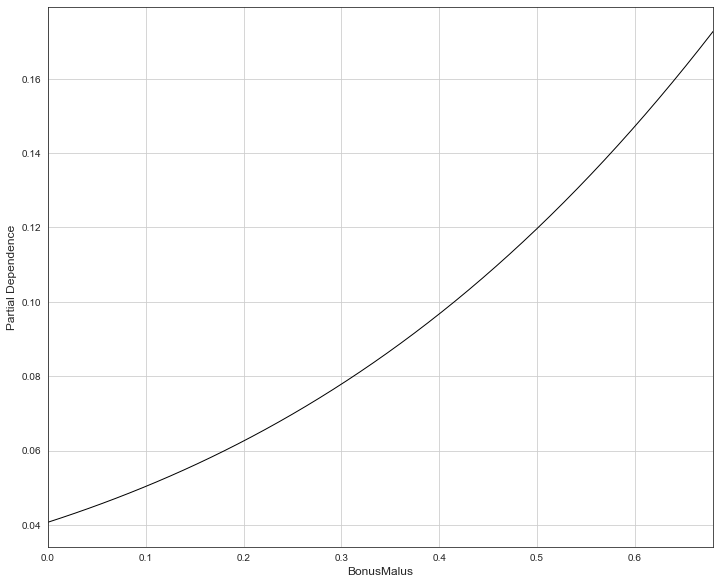

Feature 6
Agent 0


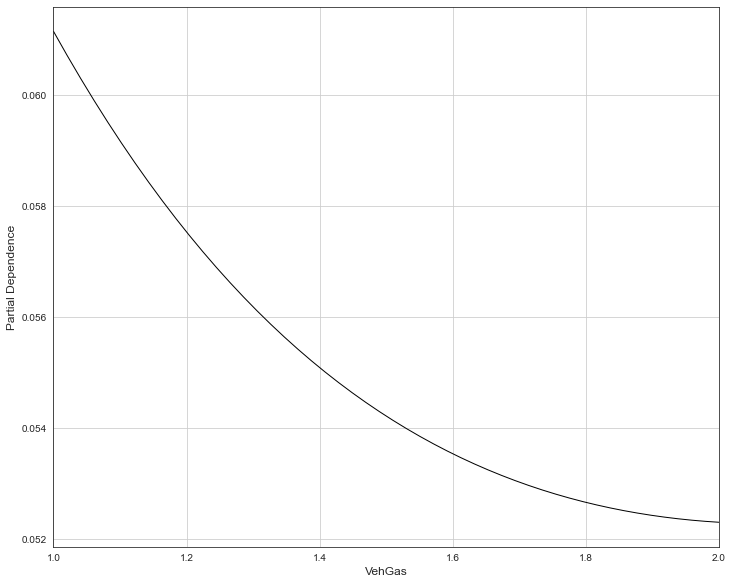

Agent 1


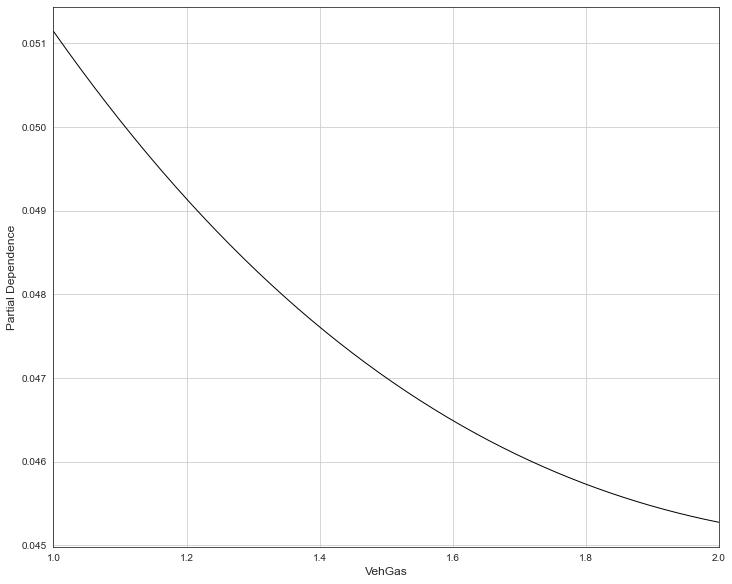

Agent 2


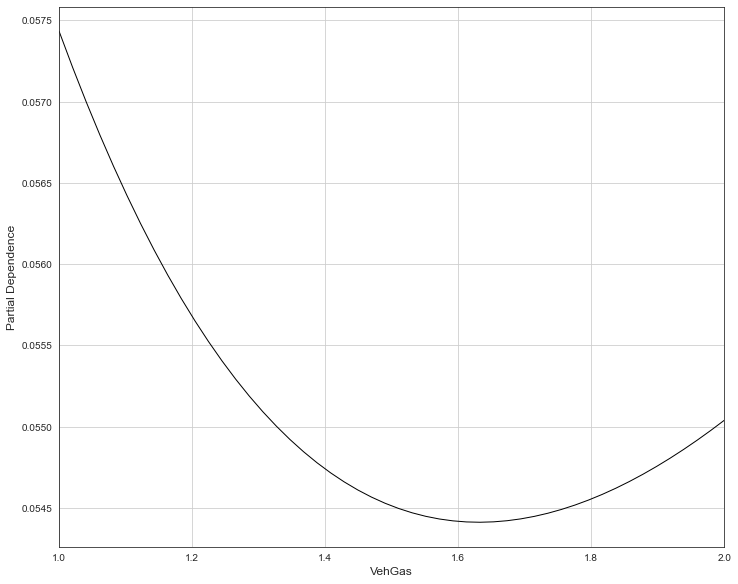

Agent 3


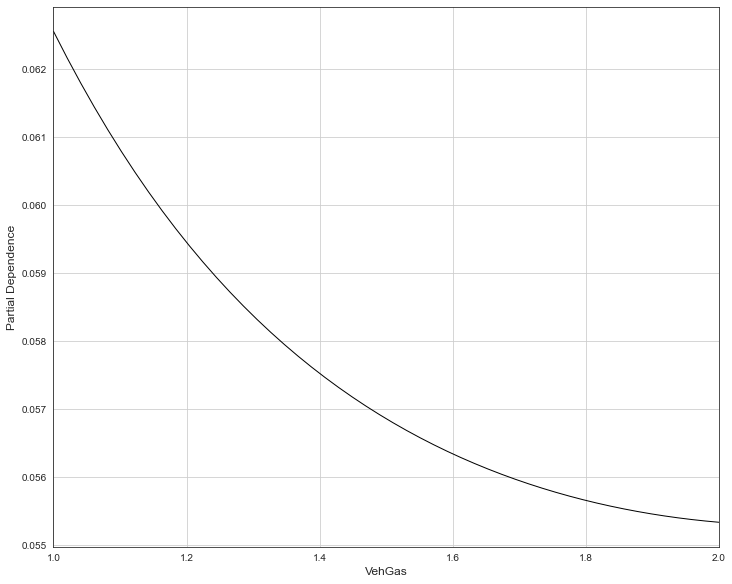

Agent 4


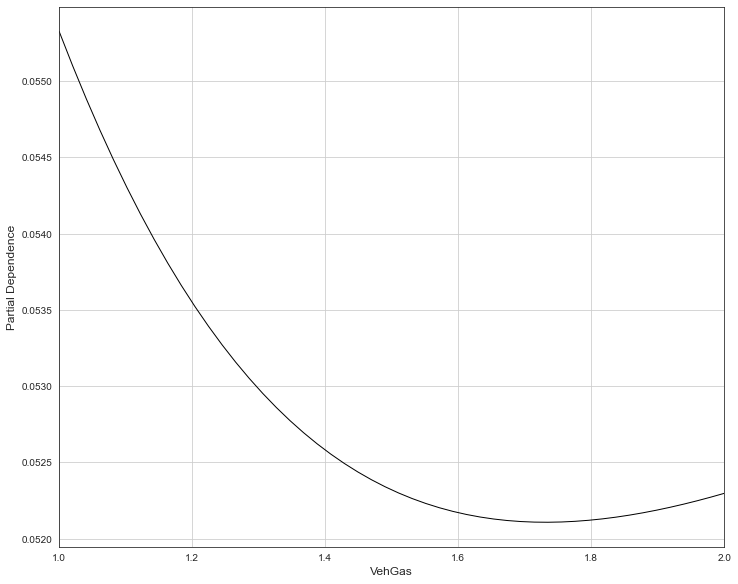

Agent 5


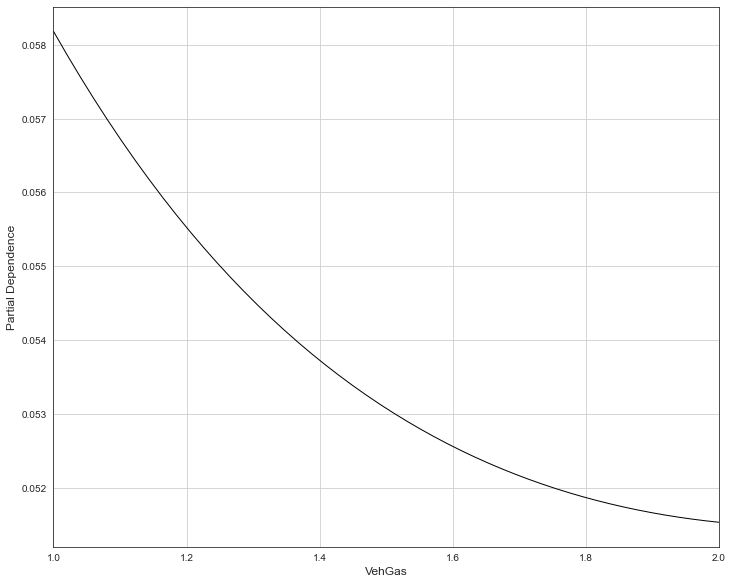

Agent 6


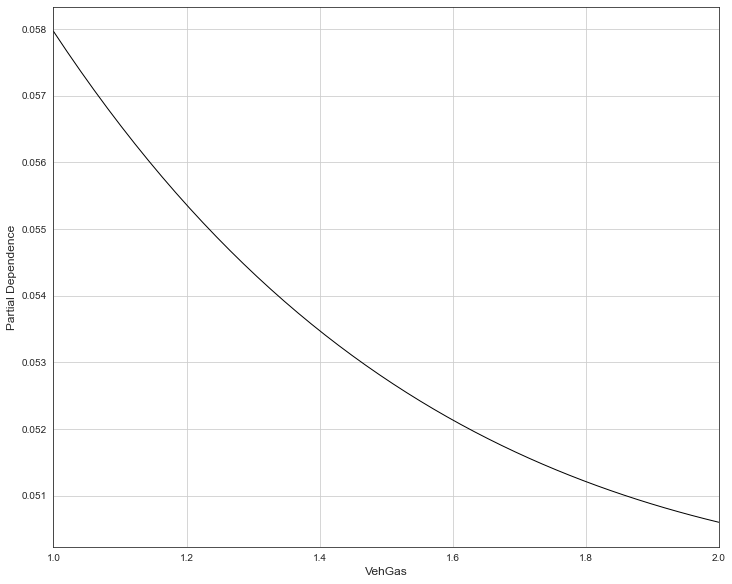

Agent 7


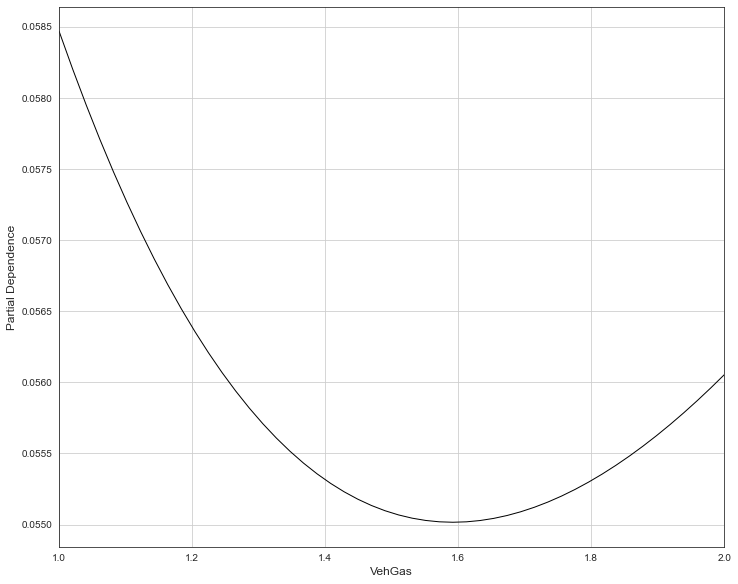

Agent 8


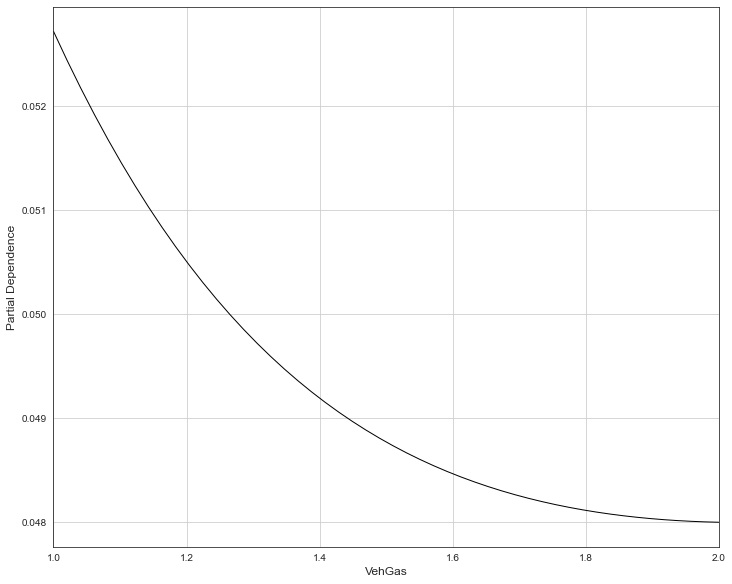

Agent 9


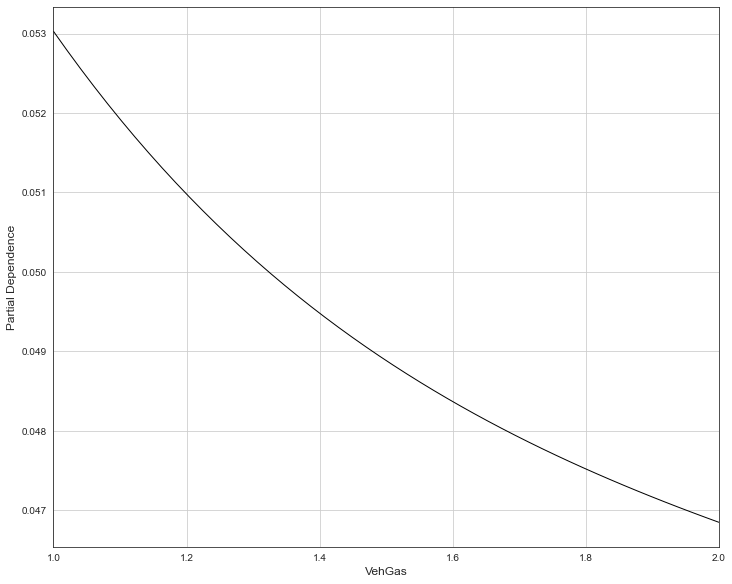

Feature 7
Agent 0


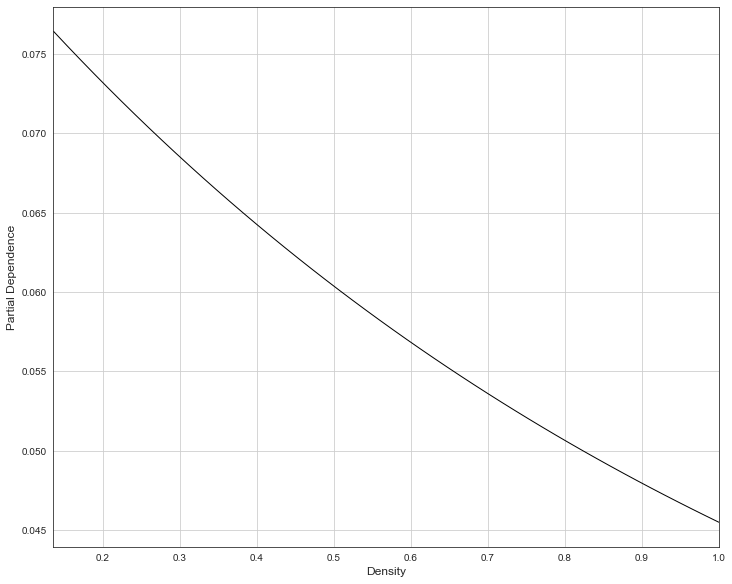

Agent 1


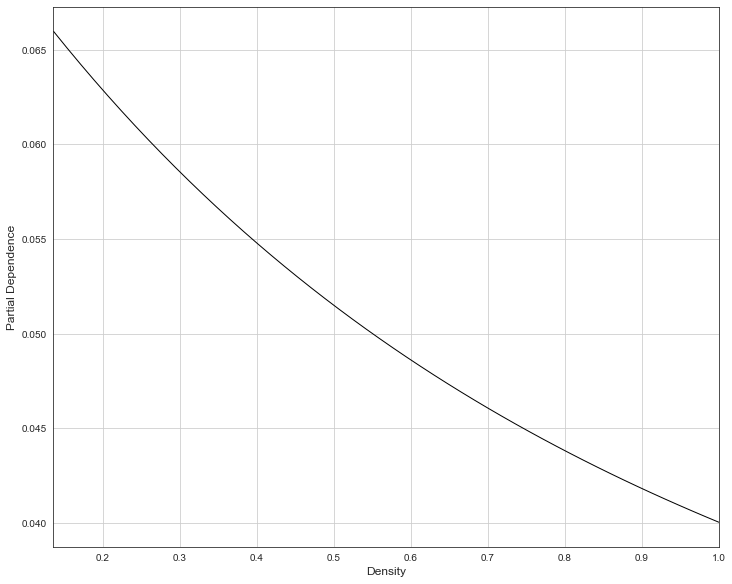

Agent 2


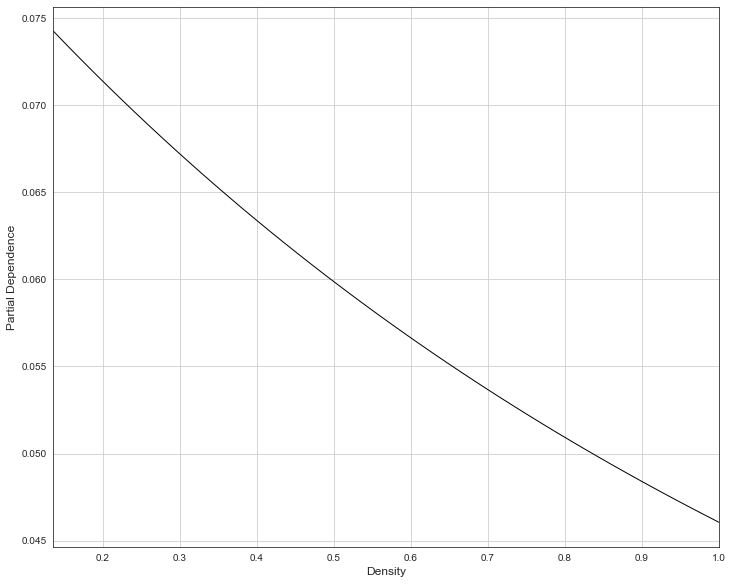

Agent 3


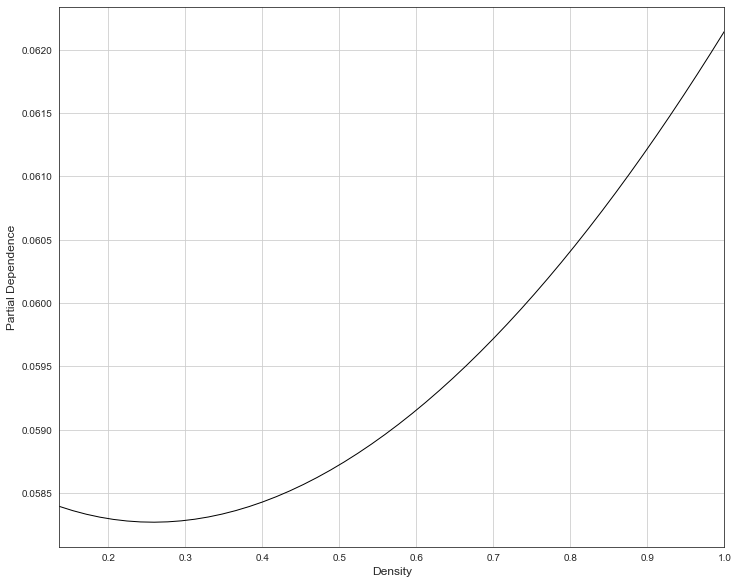

Agent 4


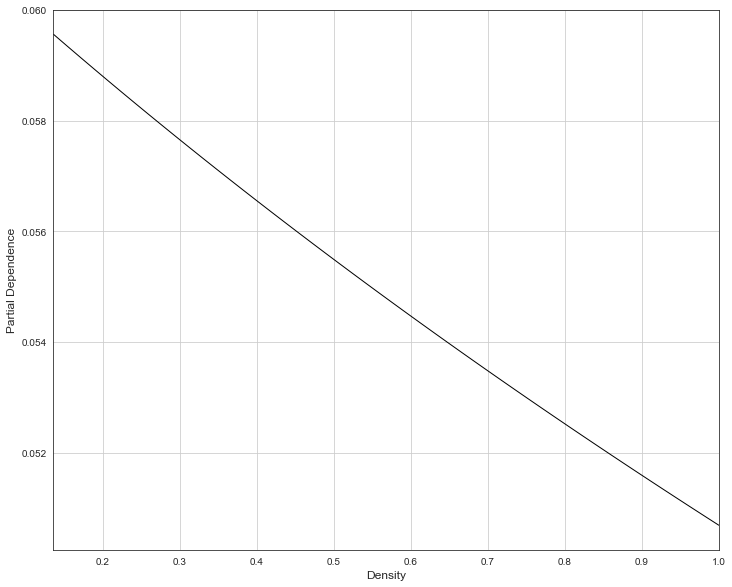

Agent 5


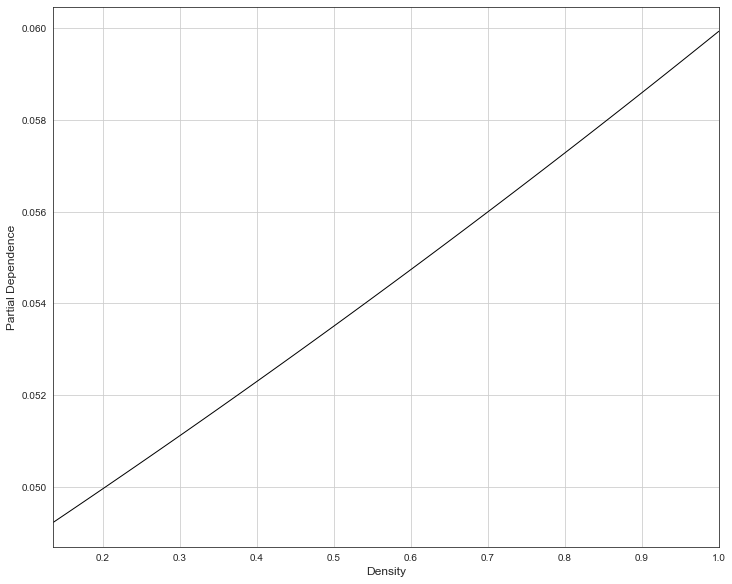

Agent 6


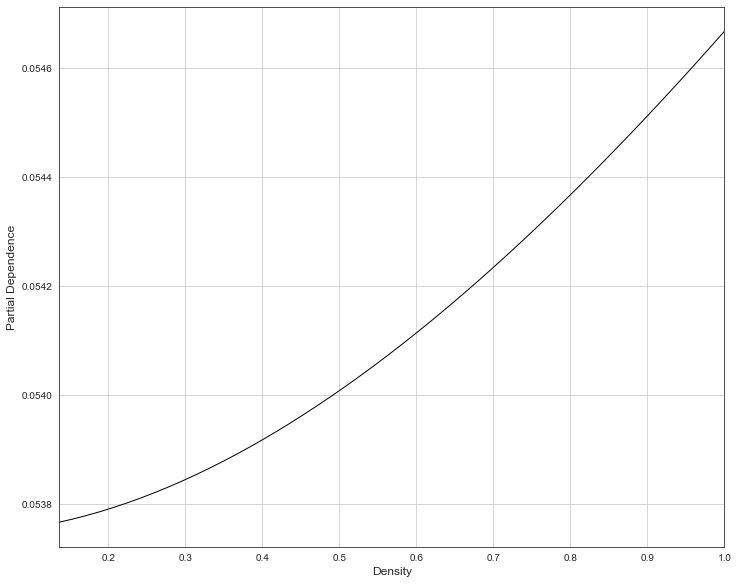

Agent 7


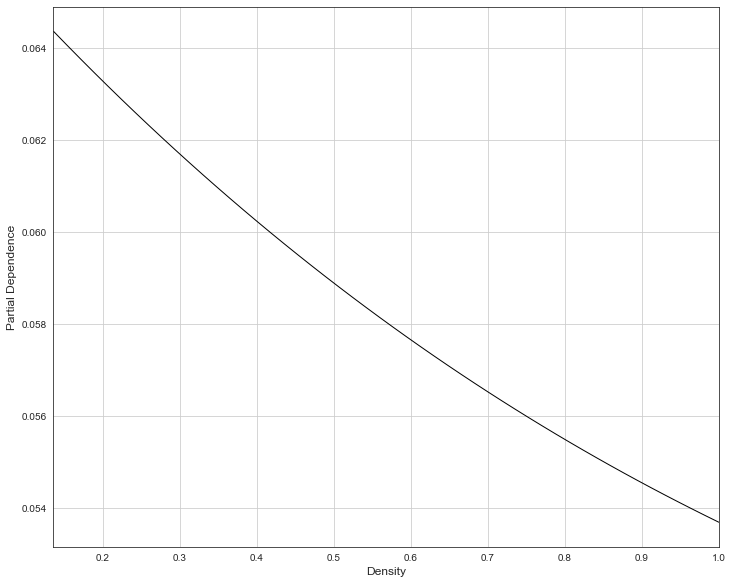

Agent 8


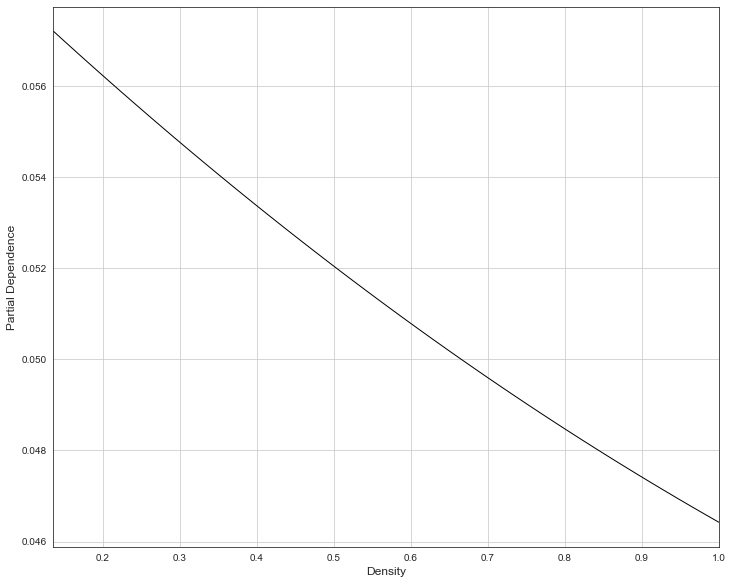

Agent 9


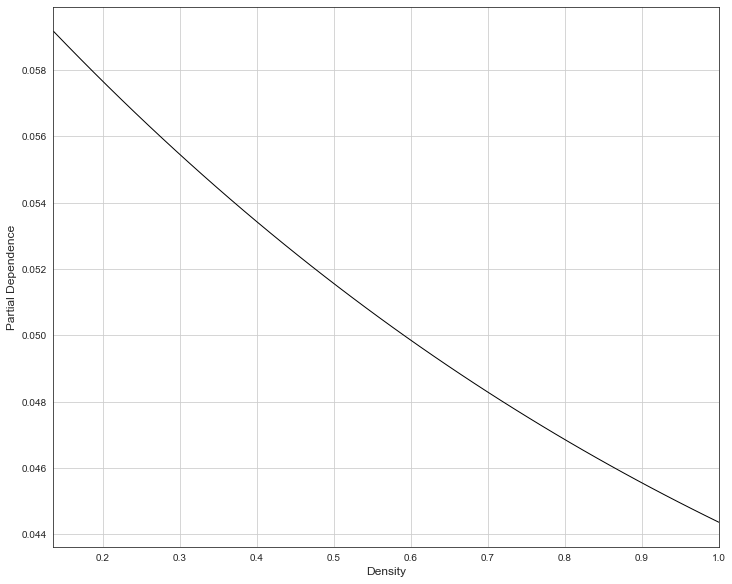

In [ ]:
for i in range(0,8):
    print('Feature '+str(i))
    for j in range(0,10):
        print('Agent '+str(j))
        loaded_agent_j_model = load_model(agent=j)
        plot_partial_dependency(loaded_agent_j_model, X_test, y_test, i)